# 결과정리
### < 2024.01.22 결과정리 >
- 맨 아래, 결과시각화를 보면 예측값(빨)이 실제종가(녹)을 따라가는 모습이다. 즉, 실제값보다 한발 느리게 예측한다.
- 그래서 실용적인 수익을 내는 유의미한 결과를 도출하려면, 종가값을 정확히 예측하는 것이 아닌, 다음날(혹은 다음캔들)의 상승 혹은 하락을 예측하는 모델로 수정해야할 것 같다.
- LSTM보다는 CNN이 학습속도도 빠르고 손실함수도 미약하게 더 낮게 나왔다. (성능은 비슷해보인다.)
- 하이퍼파라미터 조정을하면 또 어떻게 성능이 바뀔지 모르겠다.

In [12]:
# GPU Check
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
        print("Num GPUs Available: ", len(gpus))

Name: /physical_device:GPU:0 Type: GPU
Num GPUs Available:  1


# 1. 데이터 준비
- 주가데이터 전처리된 모습을 보며 학습데이터셋을 어떻게 전처리하여 준비해야할지 본다.
- 코인의 데이터를 로드하여 비슷한형태로 전처리한다.

In [3]:
import yfinance
import numpy as np
import tensorflow as tf
from keras.models import load_model, model_from_json
import os
from keras import callbacks

In [15]:
# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_83000/1698183863.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_83000/1698183863.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


# 2. 데이터셋 정규화
- 데이터 셋 정규화 : 모든 열의 이름을 숫자로 바꿈
- dataset : 모든 수치를 0과 1사이로 변환
- minmax : 각 컬럼의 최소/최대값 추출

In [72]:
# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< df >", df.head(21), "< dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

'< df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


# 데이터전처리 , 스플릿
- 시퀀스를 데이터셋으로 변환
- X는 타겟밸류(종가)를 제외한 피쳐들, 타갯밸류컬럼(종가)는 y 된다.
- X : 10일분의 데이터묶음이 5021개 (4개의 컬럼)
- y : X의 각 묶음의 마지막날의 다음날데이터(4개의 컬럼)  
- X : (5021, 10, 4) : 10행,4열의 2차원행렬이 5021개 있다. (3차원)
- y : (5021, 4) : 5021개의 행과 4개의 열 (2차원)
- 최종결과 x : (5020,10,4) , y : (5020,) 
- y는 각각의 x에 대응된 결과값(최종예상종가값 = 타겟밸류)

In [87]:
def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)
# 다음날 종가데이터와 맵핑하기 위해 한스텝씩 오프셋정렬한다.
# 기존 오픈소스에 아래부분을 넣었는데, 왜 한번 더 오프셋정렬하는지 이해가안감. 나는 주석처리했더니 손실함수가 더 적게나옴
# X = X[:-1]
# y = y[1:]

X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

# print("< Last X >\n",X[:3], X.shape, len(X))
print(" < last y > \n",y[:10], y.shape)
print(" < test y > \n",y_test[:10])
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

< X > 
 [[[0.0097097  0.01049631 0.00943526 0.01045606]
  [0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]]

 [[0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]
  [0.00923281 0.0097041  0.00928058 0.00947997]]] (5021, 10, 4)
< y > 
 [[0.00

# CNN

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(
    filters=128,
    kernel_size=3,
    activation='relu',
    input_shape=(10,4)))
model.add(Conv1D(
    filters=64,
    kernel_size=3,
    activation='relu'
))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

# 네트워크 훈련 / 저장
- ModelCheckpoint : Keras API에서 제공하는 콜백(callback) 중 하나로, 모델을 학습하는 동안 특정 조건을 만족하는 시점에 모델의 가중치를 자동으로 저장 
  
여기서는 검증 데이터셋의 손실이 가장 낮을 때 모델의 가중치를 저장

In [30]:
# 학습 후, 콜백 저장
import os
from keras import callbacks
epochs = 5000
verbosity = 2
dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
os.chdir(dirx)
h5 = 'CNN_network.h5' # 학습된 모델의 최적의 가중치 저장
checkpoint = callbacks.ModelCheckpoint(h5,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='auto',
                                      period=1)
callback = [checkpoint]
json = 'CNN_network.json' # 모델 저장
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=len(X_train) // 4,
                   validation_data = (X_test, y_test),
                   verbose = verbosity,
                   callbacks = callback)

Epoch 1/5000
5/5 - 0s - loss: 4.4979e-05 - val_loss: 1.6807e-06 - 126ms/epoch - 25ms/step
Epoch 2/5000
5/5 - 0s - loss: 4.3378e-05 - val_loss: 6.9629e-07 - 48ms/epoch - 10ms/step
Epoch 3/5000
5/5 - 0s - loss: 3.5751e-05 - val_loss: 7.5888e-07 - 38ms/epoch - 8ms/step
Epoch 4/5000
5/5 - 0s - loss: 5.8369e-05 - val_loss: 9.1922e-07 - 45ms/epoch - 9ms/step
Epoch 5/5000
5/5 - 0s - loss: 4.0704e-05 - val_loss: 1.0181e-06 - 40ms/epoch - 8ms/step
Epoch 6/5000
5/5 - 0s - loss: 3.5597e-05 - val_loss: 5.6973e-07 - 43ms/epoch - 9ms/step
Epoch 7/5000
5/5 - 0s - loss: 3.4352e-05 - val_loss: 1.0148e-06 - 42ms/epoch - 8ms/step
Epoch 8/5000
5/5 - 0s - loss: 3.3965e-05 - val_loss: 8.8735e-07 - 39ms/epoch - 8ms/step
Epoch 9/5000
5/5 - 0s - loss: 3.0477e-05 - val_loss: 6.2657e-07 - 43ms/epoch - 9ms/step
Epoch 10/5000
5/5 - 0s - loss: 3.1625e-05 - val_loss: 8.5818e-07 - 42ms/epoch - 8ms/step
Epoch 11/5000
5/5 - 0s - loss: 3.2114e-05 - val_loss: 7.0886e-07 - 43ms/epoch - 9ms/step
Epoch 12/5000
5/5 - 0s - lo

Epoch 92/5000
5/5 - 0s - loss: 4.6135e-05 - val_loss: 6.5040e-07 - 39ms/epoch - 8ms/step
Epoch 93/5000
5/5 - 0s - loss: 3.1619e-05 - val_loss: 6.5360e-07 - 37ms/epoch - 7ms/step
Epoch 94/5000
5/5 - 0s - loss: 3.7572e-05 - val_loss: 1.0764e-06 - 39ms/epoch - 8ms/step
Epoch 95/5000
5/5 - 0s - loss: 3.2434e-05 - val_loss: 7.5353e-07 - 34ms/epoch - 7ms/step
Epoch 96/5000
5/5 - 0s - loss: 3.1263e-05 - val_loss: 5.5782e-07 - 39ms/epoch - 8ms/step
Epoch 97/5000
5/5 - 0s - loss: 3.0360e-05 - val_loss: 9.1697e-07 - 36ms/epoch - 7ms/step
Epoch 98/5000
5/5 - 0s - loss: 4.0276e-05 - val_loss: 9.6798e-07 - 34ms/epoch - 7ms/step
Epoch 99/5000
5/5 - 0s - loss: 3.4672e-05 - val_loss: 8.0457e-07 - 40ms/epoch - 8ms/step
Epoch 100/5000
5/5 - 0s - loss: 3.9695e-05 - val_loss: 6.4074e-07 - 33ms/epoch - 7ms/step
Epoch 101/5000
5/5 - 0s - loss: 3.3602e-05 - val_loss: 6.0016e-07 - 32ms/epoch - 6ms/step
Epoch 102/5000
5/5 - 0s - loss: 4.6113e-05 - val_loss: 7.0404e-07 - 35ms/epoch - 7ms/step
Epoch 103/5000
5/5

5/5 - 0s - loss: 2.9683e-05 - val_loss: 5.3173e-07 - 38ms/epoch - 8ms/step
Epoch 184/5000
5/5 - 0s - loss: 2.9617e-05 - val_loss: 5.8977e-07 - 36ms/epoch - 7ms/step
Epoch 185/5000
5/5 - 0s - loss: 3.0732e-05 - val_loss: 7.0817e-07 - 33ms/epoch - 7ms/step
Epoch 186/5000
5/5 - 0s - loss: 2.9859e-05 - val_loss: 5.4015e-07 - 31ms/epoch - 6ms/step
Epoch 187/5000
5/5 - 0s - loss: 3.0258e-05 - val_loss: 6.1204e-07 - 38ms/epoch - 8ms/step
Epoch 188/5000
5/5 - 0s - loss: 3.1604e-05 - val_loss: 5.9753e-07 - 30ms/epoch - 6ms/step
Epoch 189/5000
5/5 - 0s - loss: 3.2295e-05 - val_loss: 5.6908e-07 - 35ms/epoch - 7ms/step
Epoch 190/5000
5/5 - 0s - loss: 2.9029e-05 - val_loss: 9.2638e-07 - 32ms/epoch - 6ms/step
Epoch 191/5000
5/5 - 0s - loss: 3.8245e-05 - val_loss: 7.0947e-07 - 39ms/epoch - 8ms/step
Epoch 192/5000
5/5 - 0s - loss: 4.3427e-05 - val_loss: 6.8474e-07 - 31ms/epoch - 6ms/step
Epoch 193/5000
5/5 - 0s - loss: 3.6785e-05 - val_loss: 8.0374e-07 - 37ms/epoch - 7ms/step
Epoch 194/5000
5/5 - 0s -

Epoch 275/5000
5/5 - 0s - loss: 3.2153e-05 - val_loss: 9.5329e-07 - 31ms/epoch - 6ms/step
Epoch 276/5000
5/5 - 0s - loss: 2.9245e-05 - val_loss: 5.9495e-07 - 41ms/epoch - 8ms/step
Epoch 277/5000
5/5 - 0s - loss: 3.1366e-05 - val_loss: 7.3242e-07 - 30ms/epoch - 6ms/step
Epoch 278/5000
5/5 - 0s - loss: 2.9302e-05 - val_loss: 9.9509e-07 - 37ms/epoch - 7ms/step
Epoch 279/5000
5/5 - 0s - loss: 2.9328e-05 - val_loss: 6.1141e-07 - 30ms/epoch - 6ms/step
Epoch 280/5000
5/5 - 0s - loss: 3.1713e-05 - val_loss: 5.2458e-07 - 44ms/epoch - 9ms/step
Epoch 281/5000
5/5 - 0s - loss: 3.1403e-05 - val_loss: 4.9743e-07 - 45ms/epoch - 9ms/step
Epoch 282/5000
5/5 - 0s - loss: 3.2182e-05 - val_loss: 7.5705e-07 - 38ms/epoch - 8ms/step
Epoch 283/5000
5/5 - 0s - loss: 2.8293e-05 - val_loss: 1.2578e-06 - 37ms/epoch - 7ms/step
Epoch 284/5000
5/5 - 0s - loss: 2.9184e-05 - val_loss: 7.5001e-07 - 38ms/epoch - 8ms/step
Epoch 285/5000
5/5 - 0s - loss: 2.8131e-05 - val_loss: 6.6150e-07 - 41ms/epoch - 8ms/step
Epoch 286/

5/5 - 0s - loss: 3.7202e-05 - val_loss: 6.4322e-07 - 39ms/epoch - 8ms/step
Epoch 367/5000
5/5 - 0s - loss: 3.2347e-05 - val_loss: 5.7984e-07 - 35ms/epoch - 7ms/step
Epoch 368/5000
5/5 - 0s - loss: 5.8681e-05 - val_loss: 4.9874e-07 - 35ms/epoch - 7ms/step
Epoch 369/5000
5/5 - 0s - loss: 8.1713e-05 - val_loss: 1.3199e-06 - 38ms/epoch - 8ms/step
Epoch 370/5000
5/5 - 0s - loss: 5.6662e-05 - val_loss: 4.9532e-07 - 37ms/epoch - 7ms/step
Epoch 371/5000
5/5 - 0s - loss: 4.7940e-05 - val_loss: 6.4877e-07 - 36ms/epoch - 7ms/step
Epoch 372/5000
5/5 - 0s - loss: 4.6066e-05 - val_loss: 1.0650e-06 - 30ms/epoch - 6ms/step
Epoch 373/5000
5/5 - 0s - loss: 4.3825e-05 - val_loss: 4.9125e-07 - 38ms/epoch - 8ms/step
Epoch 374/5000
5/5 - 0s - loss: 3.2793e-05 - val_loss: 5.4164e-07 - 37ms/epoch - 7ms/step
Epoch 375/5000
5/5 - 0s - loss: 3.2446e-05 - val_loss: 6.3187e-07 - 30ms/epoch - 6ms/step
Epoch 376/5000
5/5 - 0s - loss: 3.4305e-05 - val_loss: 5.6905e-07 - 37ms/epoch - 7ms/step
Epoch 377/5000
5/5 - 0s -

Epoch 458/5000
5/5 - 0s - loss: 3.6285e-05 - val_loss: 5.8965e-07 - 29ms/epoch - 6ms/step
Epoch 459/5000
5/5 - 0s - loss: 3.6776e-05 - val_loss: 4.9899e-07 - 37ms/epoch - 7ms/step
Epoch 460/5000
5/5 - 0s - loss: 4.1748e-05 - val_loss: 6.3909e-07 - 29ms/epoch - 6ms/step
Epoch 461/5000
5/5 - 0s - loss: 3.7167e-05 - val_loss: 7.1415e-07 - 33ms/epoch - 7ms/step
Epoch 462/5000
5/5 - 0s - loss: 4.0070e-05 - val_loss: 5.7375e-07 - 32ms/epoch - 6ms/step
Epoch 463/5000
5/5 - 0s - loss: 4.9197e-05 - val_loss: 5.4348e-07 - 31ms/epoch - 6ms/step
Epoch 464/5000
5/5 - 0s - loss: 6.7234e-05 - val_loss: 6.9530e-07 - 31ms/epoch - 6ms/step
Epoch 465/5000
5/5 - 0s - loss: 4.9670e-05 - val_loss: 6.7490e-07 - 37ms/epoch - 7ms/step
Epoch 466/5000
5/5 - 0s - loss: 4.7405e-05 - val_loss: 5.7469e-07 - 29ms/epoch - 6ms/step
Epoch 467/5000
5/5 - 0s - loss: 3.9950e-05 - val_loss: 9.1051e-07 - 36ms/epoch - 7ms/step
Epoch 468/5000
5/5 - 0s - loss: 3.8968e-05 - val_loss: 7.9905e-07 - 29ms/epoch - 6ms/step
Epoch 469/

5/5 - 0s - loss: 3.5304e-05 - val_loss: 7.3667e-07 - 28ms/epoch - 6ms/step
Epoch 550/5000
5/5 - 0s - loss: 3.3732e-05 - val_loss: 5.5245e-07 - 35ms/epoch - 7ms/step
Epoch 551/5000
5/5 - 0s - loss: 3.1500e-05 - val_loss: 7.4263e-07 - 32ms/epoch - 6ms/step
Epoch 552/5000
5/5 - 0s - loss: 3.1482e-05 - val_loss: 6.2657e-07 - 31ms/epoch - 6ms/step
Epoch 553/5000
5/5 - 0s - loss: 3.1451e-05 - val_loss: 8.1521e-07 - 31ms/epoch - 6ms/step
Epoch 554/5000
5/5 - 0s - loss: 3.1264e-05 - val_loss: 7.1721e-07 - 38ms/epoch - 8ms/step
Epoch 555/5000
5/5 - 0s - loss: 3.3365e-05 - val_loss: 6.3339e-07 - 31ms/epoch - 6ms/step
Epoch 556/5000
5/5 - 0s - loss: 3.4561e-05 - val_loss: 8.5188e-07 - 36ms/epoch - 7ms/step
Epoch 557/5000
5/5 - 0s - loss: 3.7027e-05 - val_loss: 6.1302e-07 - 33ms/epoch - 7ms/step
Epoch 558/5000
5/5 - 0s - loss: 3.4666e-05 - val_loss: 5.1944e-07 - 35ms/epoch - 7ms/step
Epoch 559/5000
5/5 - 0s - loss: 6.4002e-05 - val_loss: 6.9044e-07 - 35ms/epoch - 7ms/step
Epoch 560/5000
5/5 - 0s -

Epoch 641/5000
5/5 - 0s - loss: 5.0086e-05 - val_loss: 6.5909e-07 - 32ms/epoch - 6ms/step
Epoch 642/5000
5/5 - 0s - loss: 7.4026e-05 - val_loss: 1.1909e-06 - 32ms/epoch - 6ms/step
Epoch 643/5000
5/5 - 0s - loss: 7.4864e-05 - val_loss: 5.2422e-07 - 40ms/epoch - 8ms/step
Epoch 644/5000
5/5 - 0s - loss: 5.7161e-05 - val_loss: 5.3577e-07 - 28ms/epoch - 6ms/step
Epoch 645/5000
5/5 - 0s - loss: 5.8255e-05 - val_loss: 6.9446e-07 - 35ms/epoch - 7ms/step
Epoch 646/5000
5/5 - 0s - loss: 5.8940e-05 - val_loss: 8.3231e-07 - 33ms/epoch - 7ms/step
Epoch 647/5000
5/5 - 0s - loss: 6.2101e-05 - val_loss: 1.6980e-06 - 32ms/epoch - 6ms/step
Epoch 648/5000
5/5 - 0s - loss: 4.9256e-05 - val_loss: 7.0087e-07 - 33ms/epoch - 7ms/step
Epoch 649/5000
5/5 - 0s - loss: 3.9956e-05 - val_loss: 6.9999e-07 - 36ms/epoch - 7ms/step
Epoch 650/5000
5/5 - 0s - loss: 3.6146e-05 - val_loss: 1.9959e-06 - 30ms/epoch - 6ms/step
Epoch 651/5000
5/5 - 0s - loss: 3.8475e-05 - val_loss: 7.5095e-07 - 36ms/epoch - 7ms/step
Epoch 652/

5/5 - 0s - loss: 9.5373e-05 - val_loss: 7.7364e-07 - 32ms/epoch - 6ms/step
Epoch 733/5000
5/5 - 0s - loss: 6.2053e-05 - val_loss: 3.7993e-06 - 39ms/epoch - 8ms/step
Epoch 734/5000
5/5 - 0s - loss: 5.4477e-05 - val_loss: 1.0836e-06 - 28ms/epoch - 6ms/step
Epoch 735/5000
5/5 - 0s - loss: 4.9494e-05 - val_loss: 8.6541e-07 - 37ms/epoch - 7ms/step
Epoch 736/5000
5/5 - 0s - loss: 5.0816e-05 - val_loss: 8.3113e-07 - 33ms/epoch - 7ms/step
Epoch 737/5000
5/5 - 0s - loss: 6.7508e-05 - val_loss: 1.7557e-06 - 31ms/epoch - 6ms/step
Epoch 738/5000
5/5 - 0s - loss: 5.9477e-05 - val_loss: 8.5611e-07 - 31ms/epoch - 6ms/step
Epoch 739/5000
5/5 - 0s - loss: 6.2714e-05 - val_loss: 5.7996e-07 - 35ms/epoch - 7ms/step
Epoch 740/5000
5/5 - 0s - loss: 4.2184e-05 - val_loss: 1.2835e-06 - 36ms/epoch - 7ms/step
Epoch 741/5000
5/5 - 0s - loss: 6.4585e-05 - val_loss: 8.8015e-07 - 31ms/epoch - 6ms/step
Epoch 742/5000
5/5 - 0s - loss: 4.6294e-05 - val_loss: 5.4367e-07 - 35ms/epoch - 7ms/step
Epoch 743/5000
5/5 - 0s -

Epoch 824/5000
5/5 - 0s - loss: 8.3099e-05 - val_loss: 7.3814e-07 - 31ms/epoch - 6ms/step
Epoch 825/5000
5/5 - 0s - loss: 5.3138e-05 - val_loss: 8.9599e-07 - 33ms/epoch - 7ms/step
Epoch 826/5000
5/5 - 0s - loss: 4.3069e-05 - val_loss: 8.0763e-07 - 32ms/epoch - 6ms/step
Epoch 827/5000
5/5 - 0s - loss: 3.7560e-05 - val_loss: 1.8759e-06 - 36ms/epoch - 7ms/step
Epoch 828/5000
5/5 - 0s - loss: 4.1104e-05 - val_loss: 6.7136e-07 - 35ms/epoch - 7ms/step
Epoch 829/5000
5/5 - 0s - loss: 5.0909e-05 - val_loss: 6.1600e-07 - 29ms/epoch - 6ms/step
Epoch 830/5000
5/5 - 0s - loss: 5.6873e-05 - val_loss: 7.5673e-07 - 36ms/epoch - 7ms/step
Epoch 831/5000
5/5 - 0s - loss: 4.3877e-05 - val_loss: 5.2252e-07 - 36ms/epoch - 7ms/step
Epoch 832/5000
5/5 - 0s - loss: 5.0117e-05 - val_loss: 9.5106e-07 - 29ms/epoch - 6ms/step
Epoch 833/5000
5/5 - 0s - loss: 3.4781e-05 - val_loss: 8.7554e-07 - 38ms/epoch - 8ms/step
Epoch 834/5000
5/5 - 0s - loss: 3.3059e-05 - val_loss: 6.3939e-07 - 29ms/epoch - 6ms/step
Epoch 835/

5/5 - 0s - loss: 3.2531e-05 - val_loss: 5.1839e-07 - 40ms/epoch - 8ms/step
Epoch 916/5000
5/5 - 0s - loss: 3.1294e-05 - val_loss: 1.1918e-06 - 32ms/epoch - 6ms/step
Epoch 917/5000
5/5 - 0s - loss: 3.4370e-05 - val_loss: 7.5542e-07 - 38ms/epoch - 8ms/step
Epoch 918/5000
5/5 - 0s - loss: 3.1417e-05 - val_loss: 5.8386e-07 - 39ms/epoch - 8ms/step
Epoch 919/5000
5/5 - 0s - loss: 3.2793e-05 - val_loss: 6.3044e-07 - 35ms/epoch - 7ms/step
Epoch 920/5000
5/5 - 0s - loss: 2.9846e-05 - val_loss: 8.2055e-07 - 41ms/epoch - 8ms/step
Epoch 921/5000
5/5 - 0s - loss: 1.1509e-04 - val_loss: 5.3259e-07 - 37ms/epoch - 7ms/step
Epoch 922/5000
5/5 - 0s - loss: 7.5513e-05 - val_loss: 6.5771e-07 - 38ms/epoch - 8ms/step
Epoch 923/5000
5/5 - 0s - loss: 7.4288e-05 - val_loss: 2.2928e-06 - 38ms/epoch - 8ms/step
Epoch 924/5000
5/5 - 0s - loss: 5.4866e-05 - val_loss: 1.2572e-06 - 36ms/epoch - 7ms/step
Epoch 925/5000
5/5 - 0s - loss: 4.8291e-05 - val_loss: 1.0883e-06 - 36ms/epoch - 7ms/step
Epoch 926/5000
5/5 - 0s -

5/5 - 0s - loss: 3.2200e-05 - val_loss: 8.8152e-07 - 37ms/epoch - 7ms/step
Epoch 1007/5000
5/5 - 0s - loss: 3.1445e-05 - val_loss: 7.4470e-07 - 35ms/epoch - 7ms/step
Epoch 1008/5000
5/5 - 0s - loss: 3.1554e-05 - val_loss: 5.5726e-07 - 33ms/epoch - 7ms/step
Epoch 1009/5000
5/5 - 0s - loss: 3.3680e-05 - val_loss: 7.2741e-07 - 33ms/epoch - 7ms/step
Epoch 1010/5000
5/5 - 0s - loss: 3.1547e-05 - val_loss: 7.8259e-07 - 36ms/epoch - 7ms/step
Epoch 1011/5000
5/5 - 0s - loss: 3.2009e-05 - val_loss: 6.9337e-07 - 30ms/epoch - 6ms/step
Epoch 1012/5000
5/5 - 0s - loss: 3.2550e-05 - val_loss: 7.0645e-07 - 37ms/epoch - 7ms/step
Epoch 1013/5000
5/5 - 0s - loss: 3.2671e-05 - val_loss: 7.7037e-07 - 33ms/epoch - 7ms/step
Epoch 1014/5000
5/5 - 0s - loss: 3.2060e-05 - val_loss: 6.4998e-07 - 36ms/epoch - 7ms/step
Epoch 1015/5000
5/5 - 0s - loss: 3.4308e-05 - val_loss: 6.6629e-07 - 31ms/epoch - 6ms/step
Epoch 1016/5000
5/5 - 0s - loss: 3.2343e-05 - val_loss: 5.8766e-07 - 35ms/epoch - 7ms/step
Epoch 1017/5000

Epoch 1097/5000
5/5 - 0s - loss: 3.3180e-05 - val_loss: 6.1605e-07 - 38ms/epoch - 8ms/step
Epoch 1098/5000
5/5 - 0s - loss: 4.0117e-05 - val_loss: 6.1147e-07 - 36ms/epoch - 7ms/step
Epoch 1099/5000
5/5 - 0s - loss: 5.7893e-05 - val_loss: 6.8195e-07 - 40ms/epoch - 8ms/step
Epoch 1100/5000
5/5 - 0s - loss: 4.3572e-05 - val_loss: 1.0428e-06 - 32ms/epoch - 6ms/step
Epoch 1101/5000
5/5 - 0s - loss: 4.3977e-05 - val_loss: 1.2495e-06 - 38ms/epoch - 8ms/step
Epoch 1102/5000
5/5 - 0s - loss: 3.9522e-05 - val_loss: 6.2956e-07 - 38ms/epoch - 8ms/step
Epoch 1103/5000
5/5 - 0s - loss: 3.8680e-05 - val_loss: 5.5362e-07 - 37ms/epoch - 7ms/step
Epoch 1104/5000
5/5 - 0s - loss: 3.7374e-05 - val_loss: 6.3417e-07 - 37ms/epoch - 7ms/step
Epoch 1105/5000
5/5 - 0s - loss: 3.7589e-05 - val_loss: 5.3034e-07 - 36ms/epoch - 7ms/step
Epoch 1106/5000
5/5 - 0s - loss: 3.9592e-05 - val_loss: 9.9736e-07 - 36ms/epoch - 7ms/step
Epoch 1107/5000
5/5 - 0s - loss: 3.7556e-05 - val_loss: 1.2001e-06 - 36ms/epoch - 7ms/step

5/5 - 0s - loss: 4.5000e-05 - val_loss: 1.1922e-06 - 38ms/epoch - 8ms/step
Epoch 1188/5000
5/5 - 0s - loss: 3.4097e-05 - val_loss: 7.6383e-07 - 40ms/epoch - 8ms/step
Epoch 1189/5000
5/5 - 0s - loss: 3.6342e-05 - val_loss: 5.1420e-07 - 32ms/epoch - 6ms/step
Epoch 1190/5000
5/5 - 0s - loss: 3.1356e-05 - val_loss: 1.6412e-06 - 41ms/epoch - 8ms/step
Epoch 1191/5000
5/5 - 0s - loss: 4.0813e-05 - val_loss: 8.7917e-07 - 37ms/epoch - 7ms/step
Epoch 1192/5000
5/5 - 0s - loss: 6.2248e-05 - val_loss: 5.4559e-07 - 33ms/epoch - 7ms/step
Epoch 1193/5000
5/5 - 0s - loss: 5.3889e-05 - val_loss: 7.1797e-07 - 37ms/epoch - 7ms/step
Epoch 1194/5000
5/5 - 0s - loss: 8.7307e-05 - val_loss: 2.2365e-06 - 35ms/epoch - 7ms/step
Epoch 1195/5000
5/5 - 0s - loss: 6.3546e-05 - val_loss: 8.1589e-07 - 36ms/epoch - 7ms/step
Epoch 1196/5000
5/5 - 0s - loss: 4.9175e-05 - val_loss: 1.6854e-06 - 41ms/epoch - 8ms/step
Epoch 1197/5000
5/5 - 0s - loss: 5.2201e-05 - val_loss: 7.0174e-07 - 37ms/epoch - 7ms/step
Epoch 1198/5000

Epoch 1278/5000
5/5 - 0s - loss: 3.3314e-05 - val_loss: 5.2585e-07 - 34ms/epoch - 7ms/step
Epoch 1279/5000
5/5 - 0s - loss: 3.3519e-05 - val_loss: 1.0211e-06 - 39ms/epoch - 8ms/step
Epoch 1280/5000
5/5 - 0s - loss: 8.1719e-05 - val_loss: 5.1885e-07 - 35ms/epoch - 7ms/step
Epoch 1281/5000
5/5 - 0s - loss: 4.8785e-05 - val_loss: 6.5305e-07 - 34ms/epoch - 7ms/step
Epoch 1282/5000
5/5 - 0s - loss: 4.3481e-05 - val_loss: 1.1536e-06 - 35ms/epoch - 7ms/step
Epoch 1283/5000
5/5 - 0s - loss: 4.5167e-05 - val_loss: 5.4436e-07 - 35ms/epoch - 7ms/step
Epoch 1284/5000
5/5 - 0s - loss: 4.9015e-05 - val_loss: 6.0096e-07 - 33ms/epoch - 7ms/step
Epoch 1285/5000
5/5 - 0s - loss: 4.1202e-05 - val_loss: 6.7795e-07 - 33ms/epoch - 7ms/step
Epoch 1286/5000
5/5 - 0s - loss: 3.7652e-05 - val_loss: 4.8702e-07 - 38ms/epoch - 8ms/step
Epoch 1287/5000
5/5 - 0s - loss: 3.8925e-05 - val_loss: 1.3418e-06 - 34ms/epoch - 7ms/step
Epoch 1288/5000
5/5 - 0s - loss: 6.7260e-05 - val_loss: 1.3251e-06 - 33ms/epoch - 7ms/step

5/5 - 0s - loss: 3.1292e-05 - val_loss: 5.1163e-07 - 34ms/epoch - 7ms/step
Epoch 1369/5000
5/5 - 0s - loss: 3.5311e-05 - val_loss: 4.9659e-07 - 35ms/epoch - 7ms/step
Epoch 1370/5000
5/5 - 0s - loss: 3.1869e-05 - val_loss: 9.9174e-07 - 40ms/epoch - 8ms/step
Epoch 1371/5000
5/5 - 0s - loss: 3.2116e-05 - val_loss: 4.9570e-07 - 30ms/epoch - 6ms/step
Epoch 1372/5000
5/5 - 0s - loss: 3.1512e-05 - val_loss: 4.9640e-07 - 35ms/epoch - 7ms/step
Epoch 1373/5000
5/5 - 0s - loss: 3.7702e-05 - val_loss: 8.9023e-07 - 39ms/epoch - 8ms/step
Epoch 1374/5000
5/5 - 0s - loss: 3.4466e-05 - val_loss: 4.6484e-07 - 35ms/epoch - 7ms/step
Epoch 1375/5000
5/5 - 0s - loss: 4.0627e-05 - val_loss: 4.9199e-07 - 39ms/epoch - 8ms/step
Epoch 1376/5000
5/5 - 0s - loss: 3.5207e-05 - val_loss: 1.5906e-06 - 36ms/epoch - 7ms/step
Epoch 1377/5000
5/5 - 0s - loss: 3.6747e-05 - val_loss: 7.3702e-07 - 37ms/epoch - 7ms/step
Epoch 1378/5000
5/5 - 0s - loss: 3.2793e-05 - val_loss: 6.3204e-07 - 38ms/epoch - 8ms/step
Epoch 1379/5000

Epoch 1459/5000
5/5 - 0s - loss: 3.0778e-05 - val_loss: 5.6141e-07 - 38ms/epoch - 8ms/step
Epoch 1460/5000
5/5 - 0s - loss: 3.0057e-05 - val_loss: 4.9321e-07 - 40ms/epoch - 8ms/step
Epoch 1461/5000
5/5 - 0s - loss: 3.1603e-05 - val_loss: 5.0137e-07 - 39ms/epoch - 8ms/step
Epoch 1462/5000
5/5 - 0s - loss: 3.1031e-05 - val_loss: 6.0291e-07 - 36ms/epoch - 7ms/step
Epoch 1463/5000
5/5 - 0s - loss: 3.6839e-05 - val_loss: 6.4777e-07 - 39ms/epoch - 8ms/step
Epoch 1464/5000
5/5 - 0s - loss: 3.2400e-05 - val_loss: 5.4234e-07 - 41ms/epoch - 8ms/step
Epoch 1465/5000
5/5 - 0s - loss: 3.5027e-05 - val_loss: 5.1704e-07 - 32ms/epoch - 6ms/step
Epoch 1466/5000
5/5 - 0s - loss: 3.1880e-05 - val_loss: 7.9592e-07 - 41ms/epoch - 8ms/step
Epoch 1467/5000
5/5 - 0s - loss: 3.2074e-05 - val_loss: 7.9573e-07 - 39ms/epoch - 8ms/step
Epoch 1468/5000
5/5 - 0s - loss: 3.1649e-05 - val_loss: 4.9619e-07 - 39ms/epoch - 8ms/step
Epoch 1469/5000
5/5 - 0s - loss: 3.1661e-05 - val_loss: 4.8234e-07 - 34ms/epoch - 7ms/step

5/5 - 0s - loss: 3.1847e-05 - val_loss: 6.0289e-07 - 32ms/epoch - 6ms/step
Epoch 1550/5000
5/5 - 0s - loss: 3.5192e-05 - val_loss: 5.3537e-07 - 42ms/epoch - 8ms/step
Epoch 1551/5000
5/5 - 0s - loss: 3.6400e-05 - val_loss: 5.8177e-07 - 30ms/epoch - 6ms/step
Epoch 1552/5000
5/5 - 0s - loss: 3.7502e-05 - val_loss: 8.3742e-07 - 36ms/epoch - 7ms/step
Epoch 1553/5000
5/5 - 0s - loss: 3.1897e-05 - val_loss: 6.0015e-07 - 31ms/epoch - 6ms/step
Epoch 1554/5000
5/5 - 0s - loss: 3.4694e-05 - val_loss: 5.4118e-07 - 35ms/epoch - 7ms/step
Epoch 1555/5000
5/5 - 0s - loss: 3.3493e-05 - val_loss: 8.5485e-07 - 35ms/epoch - 7ms/step
Epoch 1556/5000
5/5 - 0s - loss: 3.4340e-05 - val_loss: 5.2788e-07 - 35ms/epoch - 7ms/step
Epoch 1557/5000
5/5 - 0s - loss: 3.3040e-05 - val_loss: 5.8149e-07 - 31ms/epoch - 6ms/step
Epoch 1558/5000
5/5 - 0s - loss: 3.1112e-05 - val_loss: 9.7796e-07 - 35ms/epoch - 7ms/step
Epoch 1559/5000
5/5 - 0s - loss: 3.1326e-05 - val_loss: 5.3538e-07 - 36ms/epoch - 7ms/step
Epoch 1560/5000

Epoch 1640/5000
5/5 - 0s - loss: 3.0115e-05 - val_loss: 1.1156e-06 - 30ms/epoch - 6ms/step
Epoch 1641/5000
5/5 - 0s - loss: 9.9193e-05 - val_loss: 5.4507e-07 - 37ms/epoch - 7ms/step
Epoch 1642/5000
5/5 - 0s - loss: 5.1047e-05 - val_loss: 1.5323e-06 - 35ms/epoch - 7ms/step
Epoch 1643/5000
5/5 - 0s - loss: 4.6152e-05 - val_loss: 9.6565e-07 - 30ms/epoch - 6ms/step
Epoch 1644/5000
5/5 - 0s - loss: 4.1993e-05 - val_loss: 3.5654e-06 - 37ms/epoch - 7ms/step
Epoch 1645/5000
5/5 - 0s - loss: 4.0336e-05 - val_loss: 1.6046e-06 - 30ms/epoch - 6ms/step
Epoch 1646/5000
5/5 - 0s - loss: 3.4707e-05 - val_loss: 6.4441e-07 - 40ms/epoch - 8ms/step
Epoch 1647/5000
5/5 - 0s - loss: 3.2962e-05 - val_loss: 5.7253e-07 - 31ms/epoch - 6ms/step
Epoch 1648/5000
5/5 - 0s - loss: 3.1543e-05 - val_loss: 6.7250e-07 - 36ms/epoch - 7ms/step
Epoch 1649/5000
5/5 - 0s - loss: 3.0765e-05 - val_loss: 7.0597e-07 - 34ms/epoch - 7ms/step
Epoch 1650/5000
5/5 - 0s - loss: 3.0387e-05 - val_loss: 5.2524e-07 - 37ms/epoch - 7ms/step

5/5 - 0s - loss: 5.5047e-05 - val_loss: 4.9389e-07 - 36ms/epoch - 7ms/step
Epoch 1731/5000
5/5 - 0s - loss: 4.6796e-05 - val_loss: 8.1880e-07 - 39ms/epoch - 8ms/step
Epoch 1732/5000
5/5 - 0s - loss: 4.0374e-05 - val_loss: 1.2056e-06 - 37ms/epoch - 7ms/step
Epoch 1733/5000
5/5 - 0s - loss: 5.7574e-05 - val_loss: 5.5184e-07 - 36ms/epoch - 7ms/step
Epoch 1734/5000
5/5 - 0s - loss: 3.8297e-05 - val_loss: 5.4148e-07 - 33ms/epoch - 7ms/step
Epoch 1735/5000
5/5 - 0s - loss: 4.5366e-05 - val_loss: 4.8859e-07 - 38ms/epoch - 8ms/step
Epoch 1736/5000
5/5 - 0s - loss: 3.3973e-05 - val_loss: 1.1431e-06 - 37ms/epoch - 7ms/step
Epoch 1737/5000
5/5 - 0s - loss: 3.1315e-05 - val_loss: 5.9376e-07 - 35ms/epoch - 7ms/step
Epoch 1738/5000
5/5 - 0s - loss: 3.5161e-05 - val_loss: 5.0818e-07 - 38ms/epoch - 8ms/step
Epoch 1739/5000
5/5 - 0s - loss: 3.0986e-05 - val_loss: 7.2017e-07 - 36ms/epoch - 7ms/step
Epoch 1740/5000
5/5 - 0s - loss: 3.1541e-05 - val_loss: 7.8805e-07 - 37ms/epoch - 7ms/step
Epoch 1741/5000

Epoch 1821/5000
5/5 - 0s - loss: 3.3923e-05 - val_loss: 4.7157e-07 - 41ms/epoch - 8ms/step
Epoch 1822/5000
5/5 - 0s - loss: 3.5841e-05 - val_loss: 6.2451e-07 - 32ms/epoch - 6ms/step
Epoch 1823/5000
5/5 - 0s - loss: 3.3517e-05 - val_loss: 6.5897e-07 - 33ms/epoch - 7ms/step
Epoch 1824/5000
5/5 - 0s - loss: 3.5013e-05 - val_loss: 7.0695e-07 - 39ms/epoch - 8ms/step
Epoch 1825/5000
5/5 - 0s - loss: 3.3753e-05 - val_loss: 5.7924e-07 - 31ms/epoch - 6ms/step
Epoch 1826/5000
5/5 - 0s - loss: 3.2570e-05 - val_loss: 5.0394e-07 - 36ms/epoch - 7ms/step
Epoch 1827/5000
5/5 - 0s - loss: 3.2167e-05 - val_loss: 8.3569e-07 - 35ms/epoch - 7ms/step
Epoch 1828/5000
5/5 - 0s - loss: 3.3338e-05 - val_loss: 5.4530e-07 - 30ms/epoch - 6ms/step
Epoch 1829/5000
5/5 - 0s - loss: 4.6555e-05 - val_loss: 5.3713e-07 - 38ms/epoch - 8ms/step
Epoch 1830/5000
5/5 - 0s - loss: 3.5837e-05 - val_loss: 6.0629e-07 - 30ms/epoch - 6ms/step
Epoch 1831/5000
5/5 - 0s - loss: 3.7878e-05 - val_loss: 6.2626e-07 - 33ms/epoch - 7ms/step

5/5 - 0s - loss: 3.7574e-05 - val_loss: 6.9732e-07 - 37ms/epoch - 7ms/step
Epoch 1912/5000
5/5 - 0s - loss: 3.7161e-05 - val_loss: 6.9609e-07 - 31ms/epoch - 6ms/step
Epoch 1913/5000
5/5 - 0s - loss: 3.3830e-05 - val_loss: 6.3846e-07 - 40ms/epoch - 8ms/step
Epoch 1914/5000
5/5 - 0s - loss: 3.4553e-05 - val_loss: 8.8478e-07 - 32ms/epoch - 6ms/step
Epoch 1915/5000
5/5 - 0s - loss: 5.1524e-05 - val_loss: 1.3337e-06 - 37ms/epoch - 7ms/step
Epoch 1916/5000
5/5 - 0s - loss: 3.9778e-05 - val_loss: 1.6851e-06 - 34ms/epoch - 7ms/step
Epoch 1917/5000
5/5 - 0s - loss: 3.8237e-05 - val_loss: 1.5533e-06 - 36ms/epoch - 7ms/step
Epoch 1918/5000
5/5 - 0s - loss: 3.8181e-05 - val_loss: 1.3888e-06 - 37ms/epoch - 7ms/step
Epoch 1919/5000
5/5 - 0s - loss: 3.6689e-05 - val_loss: 5.2406e-07 - 36ms/epoch - 7ms/step
Epoch 1920/5000
5/5 - 0s - loss: 3.3525e-05 - val_loss: 8.5542e-07 - 39ms/epoch - 8ms/step
Epoch 1921/5000
5/5 - 0s - loss: 3.2728e-05 - val_loss: 7.7769e-07 - 38ms/epoch - 8ms/step
Epoch 1922/5000

Epoch 2002/5000
5/5 - 0s - loss: 4.5338e-05 - val_loss: 1.4824e-06 - 41ms/epoch - 8ms/step
Epoch 2003/5000
5/5 - 0s - loss: 3.7914e-05 - val_loss: 4.5232e-07 - 31ms/epoch - 6ms/step
Epoch 2004/5000
5/5 - 0s - loss: 3.8823e-05 - val_loss: 5.6253e-07 - 40ms/epoch - 8ms/step
Epoch 2005/5000
5/5 - 0s - loss: 3.6413e-05 - val_loss: 9.9602e-07 - 36ms/epoch - 7ms/step
Epoch 2006/5000
5/5 - 0s - loss: 3.2937e-05 - val_loss: 5.6773e-07 - 34ms/epoch - 7ms/step
Epoch 2007/5000
5/5 - 0s - loss: 3.5578e-05 - val_loss: 4.9499e-07 - 42ms/epoch - 8ms/step
Epoch 2008/5000
5/5 - 0s - loss: 3.9368e-05 - val_loss: 8.0109e-07 - 33ms/epoch - 7ms/step
Epoch 2009/5000
5/5 - 0s - loss: 3.5269e-05 - val_loss: 4.5514e-07 - 36ms/epoch - 7ms/step
Epoch 2010/5000
5/5 - 0s - loss: 3.9869e-05 - val_loss: 4.6544e-07 - 38ms/epoch - 8ms/step
Epoch 2011/5000
5/5 - 0s - loss: 3.6643e-05 - val_loss: 5.5844e-07 - 37ms/epoch - 7ms/step
Epoch 2012/5000
5/5 - 0s - loss: 3.2380e-05 - val_loss: 5.0055e-07 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 4.2388e-05 - val_loss: 6.7443e-07 - 37ms/epoch - 7ms/step
Epoch 2093/5000
5/5 - 0s - loss: 6.3301e-05 - val_loss: 4.8749e-07 - 37ms/epoch - 7ms/step
Epoch 2094/5000
5/5 - 0s - loss: 3.7832e-05 - val_loss: 9.8584e-07 - 37ms/epoch - 7ms/step
Epoch 2095/5000
5/5 - 0s - loss: 4.0653e-05 - val_loss: 4.8153e-07 - 35ms/epoch - 7ms/step
Epoch 2096/5000
5/5 - 0s - loss: 3.4280e-05 - val_loss: 6.3203e-07 - 33ms/epoch - 7ms/step
Epoch 2097/5000
5/5 - 0s - loss: 3.3916e-05 - val_loss: 5.3524e-07 - 34ms/epoch - 7ms/step
Epoch 2098/5000
5/5 - 0s - loss: 3.2639e-05 - val_loss: 4.7002e-07 - 40ms/epoch - 8ms/step
Epoch 2099/5000
5/5 - 0s - loss: 3.3334e-05 - val_loss: 6.2660e-07 - 31ms/epoch - 6ms/step
Epoch 2100/5000
5/5 - 0s - loss: 3.3963e-05 - val_loss: 4.9283e-07 - 33ms/epoch - 7ms/step
Epoch 2101/5000
5/5 - 0s - loss: 3.6978e-05 - val_loss: 4.6158e-07 - 33ms/epoch - 7ms/step
Epoch 2102/5000
5/5 - 0s - loss: 3.4902e-05 - val_loss: 5.9643e-07 - 40ms/epoch - 8ms/step
Epoch 2103/5000

5/5 - 0s - loss: 3.4465e-05 - val_loss: 5.2125e-07 - 34ms/epoch - 7ms/step
Epoch 2183/5000
5/5 - 0s - loss: 3.4686e-05 - val_loss: 5.2993e-07 - 46ms/epoch - 9ms/step
Epoch 2184/5000
5/5 - 0s - loss: 3.2683e-05 - val_loss: 6.1473e-07 - 40ms/epoch - 8ms/step
Epoch 2185/5000
5/5 - 0s - loss: 3.2387e-05 - val_loss: 6.6312e-07 - 44ms/epoch - 9ms/step
Epoch 2186/5000
5/5 - 0s - loss: 3.2221e-05 - val_loss: 4.8635e-07 - 43ms/epoch - 9ms/step
Epoch 2187/5000
5/5 - 0s - loss: 3.2718e-05 - val_loss: 5.2029e-07 - 46ms/epoch - 9ms/step
Epoch 2188/5000
5/5 - 0s - loss: 3.5918e-05 - val_loss: 5.1293e-07 - 46ms/epoch - 9ms/step
Epoch 2189/5000
5/5 - 0s - loss: 3.2305e-05 - val_loss: 5.3020e-07 - 43ms/epoch - 9ms/step
Epoch 2190/5000
5/5 - 0s - loss: 3.3944e-05 - val_loss: 5.2486e-07 - 45ms/epoch - 9ms/step
Epoch 2191/5000
5/5 - 0s - loss: 3.4726e-05 - val_loss: 4.7889e-07 - 44ms/epoch - 9ms/step
Epoch 2192/5000
5/5 - 0s - loss: 3.3442e-05 - val_loss: 4.9093e-07 - 37ms/epoch - 7ms/step
Epoch 2193/5000

Epoch 2273/5000
5/5 - 0s - loss: 3.9766e-05 - val_loss: 5.3990e-07 - 39ms/epoch - 8ms/step
Epoch 2274/5000
5/5 - 0s - loss: 3.4678e-05 - val_loss: 4.7852e-07 - 35ms/epoch - 7ms/step
Epoch 2275/5000
5/5 - 0s - loss: 3.2398e-05 - val_loss: 5.0341e-07 - 38ms/epoch - 8ms/step
Epoch 2276/5000
5/5 - 0s - loss: 3.2402e-05 - val_loss: 5.2946e-07 - 36ms/epoch - 7ms/step
Epoch 2277/5000
5/5 - 0s - loss: 4.4002e-05 - val_loss: 7.2070e-07 - 36ms/epoch - 7ms/step
Epoch 2278/5000
5/5 - 0s - loss: 3.5139e-05 - val_loss: 5.3596e-07 - 30ms/epoch - 6ms/step
Epoch 2279/5000
5/5 - 0s - loss: 3.7291e-05 - val_loss: 5.1905e-07 - 35ms/epoch - 7ms/step
Epoch 2280/5000
5/5 - 0s - loss: 3.6041e-05 - val_loss: 6.7711e-07 - 31ms/epoch - 6ms/step
Epoch 2281/5000
5/5 - 0s - loss: 3.1871e-05 - val_loss: 5.0576e-07 - 34ms/epoch - 7ms/step
Epoch 2282/5000
5/5 - 0s - loss: 3.3158e-05 - val_loss: 5.4821e-07 - 31ms/epoch - 6ms/step
Epoch 2283/5000
5/5 - 0s - loss: 4.3420e-05 - val_loss: 1.0218e-06 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 6.4062e-05 - val_loss: 4.6839e-07 - 36ms/epoch - 7ms/step
Epoch 2364/5000
5/5 - 0s - loss: 8.9938e-05 - val_loss: 1.0078e-06 - 36ms/epoch - 7ms/step
Epoch 2365/5000
5/5 - 0s - loss: 5.5694e-05 - val_loss: 2.4356e-06 - 32ms/epoch - 6ms/step
Epoch 2366/5000
5/5 - 0s - loss: 6.8806e-05 - val_loss: 6.9168e-07 - 31ms/epoch - 6ms/step
Epoch 2367/5000
5/5 - 0s - loss: 6.3079e-05 - val_loss: 6.2885e-07 - 31ms/epoch - 6ms/step
Epoch 2368/5000
5/5 - 0s - loss: 4.6775e-05 - val_loss: 9.2501e-07 - 38ms/epoch - 8ms/step
Epoch 2369/5000
5/5 - 0s - loss: 4.0930e-05 - val_loss: 4.3637e-07 - 32ms/epoch - 6ms/step
Epoch 2370/5000
5/5 - 0s - loss: 4.3593e-05 - val_loss: 4.9914e-07 - 39ms/epoch - 8ms/step
Epoch 2371/5000
5/5 - 0s - loss: 4.5994e-05 - val_loss: 4.9585e-07 - 36ms/epoch - 7ms/step
Epoch 2372/5000
5/5 - 0s - loss: 3.4606e-05 - val_loss: 4.7244e-07 - 29ms/epoch - 6ms/step
Epoch 2373/5000
5/5 - 0s - loss: 3.6370e-05 - val_loss: 5.0774e-07 - 37ms/epoch - 7ms/step
Epoch 2374/5000

Epoch 2454/5000
5/5 - 0s - loss: 3.1787e-05 - val_loss: 5.6245e-07 - 33ms/epoch - 7ms/step
Epoch 2455/5000
5/5 - 0s - loss: 3.9271e-05 - val_loss: 5.1469e-07 - 35ms/epoch - 7ms/step
Epoch 2456/5000
5/5 - 0s - loss: 3.4472e-05 - val_loss: 4.9517e-07 - 38ms/epoch - 8ms/step
Epoch 2457/5000
5/5 - 0s - loss: 3.3911e-05 - val_loss: 6.2319e-07 - 37ms/epoch - 7ms/step
Epoch 2458/5000
5/5 - 0s - loss: 3.3208e-05 - val_loss: 4.4348e-07 - 41ms/epoch - 8ms/step
Epoch 2459/5000
5/5 - 0s - loss: 3.4272e-05 - val_loss: 5.3256e-07 - 38ms/epoch - 8ms/step
Epoch 2460/5000
5/5 - 0s - loss: 3.1782e-05 - val_loss: 6.7152e-07 - 33ms/epoch - 7ms/step
Epoch 2461/5000
5/5 - 0s - loss: 3.2620e-05 - val_loss: 5.4246e-07 - 36ms/epoch - 7ms/step
Epoch 2462/5000
5/5 - 0s - loss: 3.1256e-05 - val_loss: 5.1025e-07 - 31ms/epoch - 6ms/step
Epoch 2463/5000
5/5 - 0s - loss: 3.2265e-05 - val_loss: 5.7928e-07 - 35ms/epoch - 7ms/step
Epoch 2464/5000
5/5 - 0s - loss: 3.8761e-05 - val_loss: 5.2249e-07 - 28ms/epoch - 6ms/step

5/5 - 0s - loss: 4.1813e-05 - val_loss: 5.2816e-07 - 37ms/epoch - 7ms/step
Epoch 2545/5000
5/5 - 0s - loss: 3.2898e-05 - val_loss: 6.4727e-07 - 34ms/epoch - 7ms/step
Epoch 2546/5000
5/5 - 0s - loss: 3.4085e-05 - val_loss: 5.6998e-07 - 33ms/epoch - 7ms/step
Epoch 2547/5000
5/5 - 0s - loss: 4.8109e-05 - val_loss: 6.3082e-07 - 39ms/epoch - 8ms/step
Epoch 2548/5000
5/5 - 0s - loss: 3.4981e-05 - val_loss: 7.1318e-07 - 37ms/epoch - 7ms/step
Epoch 2549/5000
5/5 - 0s - loss: 3.5114e-05 - val_loss: 5.2268e-07 - 38ms/epoch - 8ms/step
Epoch 2550/5000
5/5 - 0s - loss: 3.6221e-05 - val_loss: 4.3714e-07 - 42ms/epoch - 8ms/step
Epoch 2551/5000
5/5 - 0s - loss: 4.3913e-05 - val_loss: 5.6439e-07 - 36ms/epoch - 7ms/step
Epoch 2552/5000
5/5 - 0s - loss: 3.9146e-05 - val_loss: 8.3264e-07 - 37ms/epoch - 7ms/step
Epoch 2553/5000
5/5 - 0s - loss: 3.5350e-05 - val_loss: 7.4938e-07 - 42ms/epoch - 8ms/step
Epoch 2554/5000
5/5 - 0s - loss: 3.4310e-05 - val_loss: 6.3255e-07 - 38ms/epoch - 8ms/step
Epoch 2555/5000

Epoch 2635/5000
5/5 - 0s - loss: 3.3034e-05 - val_loss: 4.9231e-07 - 40ms/epoch - 8ms/step
Epoch 2636/5000
5/5 - 0s - loss: 3.4408e-05 - val_loss: 5.7540e-07 - 36ms/epoch - 7ms/step
Epoch 2637/5000
5/5 - 0s - loss: 6.8055e-05 - val_loss: 4.6693e-07 - 40ms/epoch - 8ms/step
Epoch 2638/5000
5/5 - 0s - loss: 3.7966e-05 - val_loss: 5.7995e-07 - 34ms/epoch - 7ms/step
Epoch 2639/5000
5/5 - 0s - loss: 3.7083e-05 - val_loss: 5.5760e-07 - 40ms/epoch - 8ms/step
Epoch 2640/5000
5/5 - 0s - loss: 3.3760e-05 - val_loss: 6.0534e-07 - 39ms/epoch - 8ms/step
Epoch 2641/5000
5/5 - 0s - loss: 3.4424e-05 - val_loss: 5.1739e-07 - 39ms/epoch - 8ms/step
Epoch 2642/5000
5/5 - 0s - loss: 3.3765e-05 - val_loss: 7.3269e-07 - 36ms/epoch - 7ms/step
Epoch 2643/5000
5/5 - 0s - loss: 3.2594e-05 - val_loss: 5.3394e-07 - 37ms/epoch - 7ms/step
Epoch 2644/5000
5/5 - 0s - loss: 3.2504e-05 - val_loss: 4.8961e-07 - 38ms/epoch - 8ms/step
Epoch 2645/5000
5/5 - 0s - loss: 3.0625e-05 - val_loss: 4.6148e-07 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 5.2138e-05 - val_loss: 5.8527e-07 - 36ms/epoch - 7ms/step
Epoch 2726/5000
5/5 - 0s - loss: 3.8675e-05 - val_loss: 6.5888e-07 - 40ms/epoch - 8ms/step
Epoch 2727/5000
5/5 - 0s - loss: 3.4676e-05 - val_loss: 8.5981e-07 - 38ms/epoch - 8ms/step
Epoch 2728/5000
5/5 - 0s - loss: 3.3767e-05 - val_loss: 5.3373e-07 - 39ms/epoch - 8ms/step
Epoch 2729/5000
5/5 - 0s - loss: 5.1878e-05 - val_loss: 5.6737e-07 - 37ms/epoch - 7ms/step
Epoch 2730/5000
5/5 - 0s - loss: 3.4659e-05 - val_loss: 4.9871e-07 - 40ms/epoch - 8ms/step
Epoch 2731/5000
5/5 - 0s - loss: 6.3851e-05 - val_loss: 4.7023e-07 - 36ms/epoch - 7ms/step
Epoch 2732/5000
5/5 - 0s - loss: 6.1447e-05 - val_loss: 1.2428e-06 - 43ms/epoch - 9ms/step
Epoch 2733/5000
5/5 - 0s - loss: 5.6331e-05 - val_loss: 1.1230e-06 - 42ms/epoch - 8ms/step
Epoch 2734/5000
5/5 - 0s - loss: 1.2049e-04 - val_loss: 5.9028e-07 - 43ms/epoch - 9ms/step
Epoch 2735/5000
5/5 - 0s - loss: 7.2426e-05 - val_loss: 5.2513e-07 - 44ms/epoch - 9ms/step
Epoch 2736/5000

Epoch 2816/5000
5/5 - 0s - loss: 3.1706e-05 - val_loss: 4.4608e-07 - 31ms/epoch - 6ms/step
Epoch 2817/5000
5/5 - 0s - loss: 3.2975e-05 - val_loss: 5.0612e-07 - 34ms/epoch - 7ms/step
Epoch 2818/5000
5/5 - 0s - loss: 3.4554e-05 - val_loss: 4.8668e-07 - 31ms/epoch - 6ms/step
Epoch 2819/5000
5/5 - 0s - loss: 3.5567e-05 - val_loss: 4.6352e-07 - 35ms/epoch - 7ms/step
Epoch 2820/5000
5/5 - 0s - loss: 3.7666e-05 - val_loss: 4.8145e-07 - 36ms/epoch - 7ms/step
Epoch 2821/5000
5/5 - 0s - loss: 3.2892e-05 - val_loss: 4.6735e-07 - 34ms/epoch - 7ms/step
Epoch 2822/5000
5/5 - 0s - loss: 3.3713e-05 - val_loss: 4.6520e-07 - 31ms/epoch - 6ms/step
Epoch 2823/5000
5/5 - 0s - loss: 3.5111e-05 - val_loss: 6.2852e-07 - 34ms/epoch - 7ms/step
Epoch 2824/5000
5/5 - 0s - loss: 3.2233e-05 - val_loss: 5.5978e-07 - 35ms/epoch - 7ms/step
Epoch 2825/5000
5/5 - 0s - loss: 3.2284e-05 - val_loss: 4.4723e-07 - 29ms/epoch - 6ms/step
Epoch 2826/5000
5/5 - 0s - loss: 3.1281e-05 - val_loss: 6.8128e-07 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 3.6775e-05 - val_loss: 8.7028e-07 - 35ms/epoch - 7ms/step
Epoch 2907/5000
5/5 - 0s - loss: 4.1036e-05 - val_loss: 4.4368e-07 - 35ms/epoch - 7ms/step
Epoch 2908/5000
5/5 - 0s - loss: 3.7684e-05 - val_loss: 9.2022e-07 - 29ms/epoch - 6ms/step
Epoch 2909/5000
5/5 - 0s - loss: 3.4827e-05 - val_loss: 9.7853e-07 - 37ms/epoch - 7ms/step
Epoch 2910/5000
5/5 - 0s - loss: 3.3673e-05 - val_loss: 6.8689e-07 - 34ms/epoch - 7ms/step
Epoch 2911/5000
5/5 - 0s - loss: 3.0996e-05 - val_loss: 5.1342e-07 - 29ms/epoch - 6ms/step
Epoch 2912/5000
5/5 - 0s - loss: 3.0186e-05 - val_loss: 4.4666e-07 - 32ms/epoch - 6ms/step
Epoch 2913/5000
5/5 - 0s - loss: 3.2028e-05 - val_loss: 5.2770e-07 - 39ms/epoch - 8ms/step
Epoch 2914/5000
5/5 - 0s - loss: 3.0334e-05 - val_loss: 5.3593e-07 - 28ms/epoch - 6ms/step
Epoch 2915/5000
5/5 - 0s - loss: 3.0145e-05 - val_loss: 4.6920e-07 - 35ms/epoch - 7ms/step
Epoch 2916/5000
5/5 - 0s - loss: 3.0710e-05 - val_loss: 4.4695e-07 - 34ms/epoch - 7ms/step
Epoch 2917/5000

Epoch 2997/5000
5/5 - 0s - loss: 3.5993e-05 - val_loss: 6.4366e-07 - 37ms/epoch - 7ms/step
Epoch 2998/5000
5/5 - 0s - loss: 7.9964e-05 - val_loss: 7.5148e-07 - 40ms/epoch - 8ms/step
Epoch 2999/5000
5/5 - 0s - loss: 3.8280e-05 - val_loss: 7.9138e-07 - 42ms/epoch - 8ms/step
Epoch 3000/5000
5/5 - 0s - loss: 4.6290e-05 - val_loss: 7.5575e-07 - 37ms/epoch - 7ms/step
Epoch 3001/5000
5/5 - 0s - loss: 3.9407e-05 - val_loss: 7.4148e-07 - 41ms/epoch - 8ms/step
Epoch 3002/5000
5/5 - 0s - loss: 3.6875e-05 - val_loss: 5.5810e-07 - 34ms/epoch - 7ms/step
Epoch 3003/5000
5/5 - 0s - loss: 3.4377e-05 - val_loss: 1.4515e-06 - 70ms/epoch - 14ms/step
Epoch 3004/5000
5/5 - 0s - loss: 3.5125e-05 - val_loss: 4.5960e-07 - 45ms/epoch - 9ms/step
Epoch 3005/5000
5/5 - 0s - loss: 8.5762e-05 - val_loss: 4.8717e-07 - 38ms/epoch - 8ms/step
Epoch 3006/5000
5/5 - 0s - loss: 4.9719e-05 - val_loss: 4.5460e-07 - 39ms/epoch - 8ms/step
Epoch 3007/5000
5/5 - 0s - loss: 5.6621e-05 - val_loss: 5.0167e-07 - 37ms/epoch - 7ms/ste

5/5 - 0s - loss: 4.5910e-05 - val_loss: 5.5547e-07 - 34ms/epoch - 7ms/step
Epoch 3088/5000
5/5 - 0s - loss: 3.8395e-05 - val_loss: 5.3358e-07 - 34ms/epoch - 7ms/step
Epoch 3089/5000
5/5 - 0s - loss: 4.3704e-05 - val_loss: 5.8724e-07 - 30ms/epoch - 6ms/step
Epoch 3090/5000
5/5 - 0s - loss: 3.6312e-05 - val_loss: 6.3193e-07 - 33ms/epoch - 7ms/step
Epoch 3091/5000
5/5 - 0s - loss: 3.5553e-05 - val_loss: 5.8983e-07 - 37ms/epoch - 7ms/step
Epoch 3092/5000
5/5 - 0s - loss: 3.2958e-05 - val_loss: 4.4568e-07 - 40ms/epoch - 8ms/step
Epoch 3093/5000
5/5 - 0s - loss: 3.3519e-05 - val_loss: 4.6709e-07 - 53ms/epoch - 11ms/step
Epoch 3094/5000
5/5 - 0s - loss: 3.3149e-05 - val_loss: 6.5287e-07 - 37ms/epoch - 7ms/step
Epoch 3095/5000
5/5 - 0s - loss: 5.5430e-05 - val_loss: 4.5524e-07 - 39ms/epoch - 8ms/step
Epoch 3096/5000
5/5 - 0s - loss: 3.8310e-05 - val_loss: 4.3638e-07 - 36ms/epoch - 7ms/step
Epoch 3097/5000
5/5 - 0s - loss: 3.8719e-05 - val_loss: 8.4265e-07 - 36ms/epoch - 7ms/step
Epoch 3098/500

Epoch 3178/5000
5/5 - 0s - loss: 6.2712e-05 - val_loss: 7.4064e-07 - 32ms/epoch - 6ms/step
Epoch 3179/5000
5/5 - 0s - loss: 5.1363e-05 - val_loss: 4.7437e-07 - 40ms/epoch - 8ms/step
Epoch 3180/5000
5/5 - 0s - loss: 4.7976e-05 - val_loss: 5.8205e-07 - 30ms/epoch - 6ms/step
Epoch 3181/5000
5/5 - 0s - loss: 3.7733e-05 - val_loss: 8.5512e-07 - 34ms/epoch - 7ms/step
Epoch 3182/5000
5/5 - 0s - loss: 3.4208e-05 - val_loss: 6.5103e-07 - 32ms/epoch - 6ms/step
Epoch 3183/5000
5/5 - 0s - loss: 3.4037e-05 - val_loss: 5.0457e-07 - 33ms/epoch - 7ms/step
Epoch 3184/5000
5/5 - 0s - loss: 3.6406e-05 - val_loss: 5.2180e-07 - 33ms/epoch - 7ms/step
Epoch 3185/5000
5/5 - 0s - loss: 3.5912e-05 - val_loss: 5.4866e-07 - 35ms/epoch - 7ms/step
Epoch 3186/5000
5/5 - 0s - loss: 3.1874e-05 - val_loss: 6.5600e-07 - 30ms/epoch - 6ms/step
Epoch 3187/5000
5/5 - 0s - loss: 3.2584e-05 - val_loss: 5.3502e-07 - 35ms/epoch - 7ms/step
Epoch 3188/5000
5/5 - 0s - loss: 3.1534e-05 - val_loss: 6.7310e-07 - 31ms/epoch - 6ms/step

5/5 - 0s - loss: 2.5795e-04 - val_loss: 4.4796e-06 - 32ms/epoch - 6ms/step
Epoch 3269/5000
5/5 - 0s - loss: 1.4740e-04 - val_loss: 7.1777e-07 - 33ms/epoch - 7ms/step
Epoch 3270/5000
5/5 - 0s - loss: 1.3057e-04 - val_loss: 2.5982e-06 - 33ms/epoch - 7ms/step
Epoch 3271/5000
5/5 - 0s - loss: 1.1951e-04 - val_loss: 3.0707e-06 - 29ms/epoch - 6ms/step
Epoch 3272/5000
5/5 - 0s - loss: 7.6049e-05 - val_loss: 1.6388e-06 - 37ms/epoch - 7ms/step
Epoch 3273/5000
5/5 - 0s - loss: 4.7337e-05 - val_loss: 2.4168e-06 - 31ms/epoch - 6ms/step
Epoch 3274/5000
5/5 - 0s - loss: 4.8028e-05 - val_loss: 1.0493e-06 - 66ms/epoch - 13ms/step
Epoch 3275/5000
5/5 - 0s - loss: 3.5197e-05 - val_loss: 6.8280e-07 - 40ms/epoch - 8ms/step
Epoch 3276/5000
5/5 - 0s - loss: 3.4765e-05 - val_loss: 6.6159e-07 - 32ms/epoch - 6ms/step
Epoch 3277/5000
5/5 - 0s - loss: 3.4521e-05 - val_loss: 5.8166e-07 - 38ms/epoch - 8ms/step
Epoch 3278/5000
5/5 - 0s - loss: 3.4523e-05 - val_loss: 4.8326e-07 - 39ms/epoch - 8ms/step
Epoch 3279/500

5/5 - 0s - loss: 3.7591e-05 - val_loss: 1.0003e-06 - 37ms/epoch - 7ms/step
Epoch 3359/5000
5/5 - 0s - loss: 4.1609e-05 - val_loss: 5.0578e-07 - 38ms/epoch - 8ms/step
Epoch 3360/5000
5/5 - 0s - loss: 3.4524e-05 - val_loss: 4.4645e-07 - 31ms/epoch - 6ms/step
Epoch 3361/5000
5/5 - 0s - loss: 3.5448e-05 - val_loss: 6.0961e-07 - 38ms/epoch - 8ms/step
Epoch 3362/5000
5/5 - 0s - loss: 3.5042e-05 - val_loss: 4.4252e-07 - 37ms/epoch - 7ms/step
Epoch 3363/5000
5/5 - 0s - loss: 3.9159e-05 - val_loss: 4.3514e-07 - 30ms/epoch - 6ms/step
Epoch 3364/5000
5/5 - 0s - loss: 3.5406e-05 - val_loss: 5.6483e-07 - 37ms/epoch - 7ms/step
Epoch 3365/5000
5/5 - 0s - loss: 3.6819e-05 - val_loss: 4.4059e-07 - 32ms/epoch - 6ms/step
Epoch 3366/5000
5/5 - 0s - loss: 3.5245e-05 - val_loss: 4.4755e-07 - 35ms/epoch - 7ms/step
Epoch 3367/5000
5/5 - 0s - loss: 3.6247e-05 - val_loss: 5.3266e-07 - 29ms/epoch - 6ms/step
Epoch 3368/5000
5/5 - 0s - loss: 3.4029e-05 - val_loss: 5.0607e-07 - 39ms/epoch - 8ms/step
Epoch 3369/5000

Epoch 3449/5000
5/5 - 0s - loss: 3.0975e-05 - val_loss: 5.8183e-07 - 43ms/epoch - 9ms/step
Epoch 3450/5000
5/5 - 0s - loss: 3.1320e-05 - val_loss: 5.2128e-07 - 30ms/epoch - 6ms/step
Epoch 3451/5000
5/5 - 0s - loss: 3.0740e-05 - val_loss: 4.3222e-07 - 36ms/epoch - 7ms/step
Epoch 3452/5000
5/5 - 0s - loss: 3.1481e-05 - val_loss: 5.1485e-07 - 29ms/epoch - 6ms/step
Epoch 3453/5000
5/5 - 0s - loss: 5.0946e-05 - val_loss: 1.0318e-06 - 33ms/epoch - 7ms/step
Epoch 3454/5000
5/5 - 0s - loss: 3.9461e-05 - val_loss: 5.5393e-07 - 32ms/epoch - 6ms/step
Epoch 3455/5000
5/5 - 0s - loss: 4.0509e-05 - val_loss: 6.3102e-07 - 33ms/epoch - 7ms/step
Epoch 3456/5000
5/5 - 0s - loss: 1.1783e-04 - val_loss: 4.8981e-07 - 34ms/epoch - 7ms/step
Epoch 3457/5000
5/5 - 0s - loss: 5.9338e-05 - val_loss: 4.5672e-07 - 30ms/epoch - 6ms/step
Epoch 3458/5000
5/5 - 0s - loss: 5.0623e-05 - val_loss: 4.4047e-07 - 35ms/epoch - 7ms/step
Epoch 3459/5000
5/5 - 0s - loss: 7.0962e-05 - val_loss: 1.0716e-06 - 31ms/epoch - 6ms/step

5/5 - 0s - loss: 3.5899e-05 - val_loss: 1.7801e-06 - 34ms/epoch - 7ms/step
Epoch 3540/5000
5/5 - 0s - loss: 3.5645e-05 - val_loss: 4.5534e-07 - 35ms/epoch - 7ms/step
Epoch 3541/5000
5/5 - 0s - loss: 3.4159e-05 - val_loss: 5.3893e-07 - 34ms/epoch - 7ms/step
Epoch 3542/5000
5/5 - 0s - loss: 3.2265e-05 - val_loss: 5.2230e-07 - 36ms/epoch - 7ms/step
Epoch 3543/5000
5/5 - 0s - loss: 3.2857e-05 - val_loss: 5.4457e-07 - 36ms/epoch - 7ms/step
Epoch 3544/5000
5/5 - 0s - loss: 3.2951e-05 - val_loss: 4.8507e-07 - 35ms/epoch - 7ms/step
Epoch 3545/5000
5/5 - 0s - loss: 3.1613e-05 - val_loss: 4.5282e-07 - 36ms/epoch - 7ms/step
Epoch 3546/5000
5/5 - 0s - loss: 3.1373e-05 - val_loss: 4.9515e-07 - 32ms/epoch - 6ms/step
Epoch 3547/5000
5/5 - 0s - loss: 3.1257e-05 - val_loss: 5.5997e-07 - 34ms/epoch - 7ms/step
Epoch 3548/5000
5/5 - 0s - loss: 3.0762e-05 - val_loss: 5.3975e-07 - 35ms/epoch - 7ms/step
Epoch 3549/5000
5/5 - 0s - loss: 3.0987e-05 - val_loss: 6.3496e-07 - 35ms/epoch - 7ms/step
Epoch 3550/5000

Epoch 3630/5000
5/5 - 0s - loss: 3.2055e-05 - val_loss: 7.8302e-07 - 39ms/epoch - 8ms/step
Epoch 3631/5000
5/5 - 0s - loss: 3.1531e-05 - val_loss: 8.4641e-07 - 34ms/epoch - 7ms/step
Epoch 3632/5000
5/5 - 0s - loss: 3.1682e-05 - val_loss: 6.6521e-07 - 38ms/epoch - 8ms/step
Epoch 3633/5000
5/5 - 0s - loss: 3.0854e-05 - val_loss: 6.8310e-07 - 31ms/epoch - 6ms/step
Epoch 3634/5000
5/5 - 0s - loss: 3.1043e-05 - val_loss: 9.2644e-07 - 36ms/epoch - 7ms/step
Epoch 3635/5000
5/5 - 0s - loss: 3.9154e-05 - val_loss: 8.0757e-07 - 31ms/epoch - 6ms/step
Epoch 3636/5000
5/5 - 0s - loss: 3.2535e-05 - val_loss: 5.3141e-07 - 35ms/epoch - 7ms/step
Epoch 3637/5000
5/5 - 0s - loss: 3.4970e-05 - val_loss: 6.5662e-07 - 30ms/epoch - 6ms/step
Epoch 3638/5000
5/5 - 0s - loss: 3.1314e-05 - val_loss: 8.5719e-07 - 39ms/epoch - 8ms/step
Epoch 3639/5000
5/5 - 0s - loss: 3.0922e-05 - val_loss: 6.4597e-07 - 34ms/epoch - 7ms/step
Epoch 3640/5000
5/5 - 0s - loss: 3.1587e-05 - val_loss: 5.3719e-07 - 36ms/epoch - 7ms/step

5/5 - 0s - loss: 4.1497e-05 - val_loss: 4.9791e-07 - 38ms/epoch - 8ms/step
Epoch 3721/5000
5/5 - 0s - loss: 3.9621e-05 - val_loss: 7.8940e-07 - 36ms/epoch - 7ms/step
Epoch 3722/5000
5/5 - 0s - loss: 3.3710e-05 - val_loss: 6.0165e-07 - 29ms/epoch - 6ms/step
Epoch 3723/5000
5/5 - 0s - loss: 3.4157e-05 - val_loss: 6.2581e-07 - 38ms/epoch - 8ms/step
Epoch 3724/5000
5/5 - 0s - loss: 4.8798e-05 - val_loss: 5.9129e-07 - 51ms/epoch - 10ms/step
Epoch 3725/5000
5/5 - 0s - loss: 3.6212e-05 - val_loss: 7.2603e-07 - 38ms/epoch - 8ms/step
Epoch 3726/5000
5/5 - 0s - loss: 3.5571e-05 - val_loss: 1.1394e-06 - 38ms/epoch - 8ms/step
Epoch 3727/5000
5/5 - 0s - loss: 3.4744e-05 - val_loss: 5.1265e-07 - 36ms/epoch - 7ms/step
Epoch 3728/5000
5/5 - 0s - loss: 3.7441e-05 - val_loss: 4.8975e-07 - 35ms/epoch - 7ms/step
Epoch 3729/5000
5/5 - 0s - loss: 3.3020e-05 - val_loss: 9.1452e-07 - 34ms/epoch - 7ms/step
Epoch 3730/5000
5/5 - 0s - loss: 3.5254e-05 - val_loss: 5.6360e-07 - 34ms/epoch - 7ms/step
Epoch 3731/500

Epoch 3811/5000
5/5 - 0s - loss: 3.3400e-05 - val_loss: 5.2723e-07 - 34ms/epoch - 7ms/step
Epoch 3812/5000
5/5 - 0s - loss: 3.3480e-05 - val_loss: 4.8553e-07 - 39ms/epoch - 8ms/step
Epoch 3813/5000
5/5 - 0s - loss: 5.5763e-05 - val_loss: 6.1669e-07 - 34ms/epoch - 7ms/step
Epoch 3814/5000
5/5 - 0s - loss: 1.8170e-04 - val_loss: 1.5158e-06 - 39ms/epoch - 8ms/step
Epoch 3815/5000
5/5 - 0s - loss: 3.0004e-04 - val_loss: 4.6148e-07 - 29ms/epoch - 6ms/step
Epoch 3816/5000
5/5 - 0s - loss: 2.7486e-04 - val_loss: 8.5267e-07 - 39ms/epoch - 8ms/step
Epoch 3817/5000
5/5 - 0s - loss: 6.2298e-04 - val_loss: 2.9961e-06 - 34ms/epoch - 7ms/step
Epoch 3818/5000
5/5 - 0s - loss: 1.9292e-04 - val_loss: 6.1554e-07 - 36ms/epoch - 7ms/step
Epoch 3819/5000
5/5 - 0s - loss: 1.7459e-04 - val_loss: 1.5196e-06 - 35ms/epoch - 7ms/step
Epoch 3820/5000
5/5 - 0s - loss: 7.8183e-05 - val_loss: 3.4444e-06 - 32ms/epoch - 6ms/step
Epoch 3821/5000
5/5 - 0s - loss: 9.5975e-05 - val_loss: 8.5488e-07 - 33ms/epoch - 7ms/step

5/5 - 0s - loss: 5.1075e-05 - val_loss: 1.6521e-06 - 34ms/epoch - 7ms/step
Epoch 3902/5000
5/5 - 0s - loss: 4.0552e-05 - val_loss: 5.1865e-07 - 34ms/epoch - 7ms/step
Epoch 3903/5000
5/5 - 0s - loss: 3.9535e-05 - val_loss: 8.0114e-07 - 36ms/epoch - 7ms/step
Epoch 3904/5000
5/5 - 0s - loss: 3.3575e-05 - val_loss: 6.2288e-07 - 37ms/epoch - 7ms/step
Epoch 3905/5000
5/5 - 0s - loss: 3.3956e-05 - val_loss: 5.8788e-07 - 36ms/epoch - 7ms/step
Epoch 3906/5000
5/5 - 0s - loss: 3.6338e-05 - val_loss: 4.5553e-07 - 37ms/epoch - 7ms/step
Epoch 3907/5000
5/5 - 0s - loss: 3.5815e-05 - val_loss: 5.0316e-07 - 34ms/epoch - 7ms/step
Epoch 3908/5000
5/5 - 0s - loss: 3.4828e-05 - val_loss: 4.9113e-07 - 41ms/epoch - 8ms/step
Epoch 3909/5000
5/5 - 0s - loss: 3.2799e-05 - val_loss: 5.1840e-07 - 34ms/epoch - 7ms/step
Epoch 3910/5000
5/5 - 0s - loss: 3.2721e-05 - val_loss: 5.6521e-07 - 34ms/epoch - 7ms/step
Epoch 3911/5000
5/5 - 0s - loss: 3.3083e-05 - val_loss: 7.4569e-07 - 37ms/epoch - 7ms/step
Epoch 3912/5000

Epoch 3992/5000
5/5 - 0s - loss: 3.4034e-05 - val_loss: 4.9847e-07 - 32ms/epoch - 6ms/step
Epoch 3993/5000
5/5 - 0s - loss: 3.9316e-05 - val_loss: 5.9372e-07 - 32ms/epoch - 6ms/step
Epoch 3994/5000
5/5 - 0s - loss: 3.5719e-05 - val_loss: 6.3451e-07 - 32ms/epoch - 6ms/step
Epoch 3995/5000
5/5 - 0s - loss: 3.7925e-05 - val_loss: 5.3917e-07 - 32ms/epoch - 6ms/step
Epoch 3996/5000
5/5 - 0s - loss: 3.6518e-05 - val_loss: 1.1547e-06 - 35ms/epoch - 7ms/step
Epoch 3997/5000
5/5 - 0s - loss: 4.0000e-05 - val_loss: 5.7028e-07 - 30ms/epoch - 6ms/step
Epoch 3998/5000
5/5 - 0s - loss: 3.4202e-05 - val_loss: 9.4648e-07 - 35ms/epoch - 7ms/step
Epoch 3999/5000
5/5 - 0s - loss: 3.4901e-05 - val_loss: 4.7525e-07 - 33ms/epoch - 7ms/step
Epoch 4000/5000
5/5 - 0s - loss: 3.3038e-05 - val_loss: 4.8892e-07 - 37ms/epoch - 7ms/step
Epoch 4001/5000
5/5 - 0s - loss: 3.2479e-05 - val_loss: 5.0592e-07 - 29ms/epoch - 6ms/step
Epoch 4002/5000
5/5 - 0s - loss: 3.1722e-05 - val_loss: 5.2266e-07 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 3.1647e-05 - val_loss: 5.4760e-07 - 34ms/epoch - 7ms/step
Epoch 4083/5000
5/5 - 0s - loss: 3.0997e-05 - val_loss: 5.1447e-07 - 40ms/epoch - 8ms/step
Epoch 4084/5000
5/5 - 0s - loss: 3.0992e-05 - val_loss: 5.2194e-07 - 31ms/epoch - 6ms/step
Epoch 4085/5000
5/5 - 0s - loss: 3.0973e-05 - val_loss: 4.7734e-07 - 38ms/epoch - 8ms/step
Epoch 4086/5000
5/5 - 0s - loss: 3.1315e-05 - val_loss: 5.8153e-07 - 39ms/epoch - 8ms/step
Epoch 4087/5000
5/5 - 0s - loss: 3.0372e-05 - val_loss: 5.6771e-07 - 35ms/epoch - 7ms/step
Epoch 4088/5000
5/5 - 0s - loss: 3.0921e-05 - val_loss: 5.4672e-07 - 35ms/epoch - 7ms/step
Epoch 4089/5000
5/5 - 0s - loss: 3.0389e-05 - val_loss: 5.0368e-07 - 36ms/epoch - 7ms/step
Epoch 4090/5000
5/5 - 0s - loss: 3.6739e-05 - val_loss: 5.0132e-07 - 35ms/epoch - 7ms/step
Epoch 4091/5000
5/5 - 0s - loss: 3.4892e-05 - val_loss: 7.4078e-07 - 38ms/epoch - 8ms/step
Epoch 4092/5000
5/5 - 0s - loss: 3.7479e-05 - val_loss: 6.7043e-07 - 39ms/epoch - 8ms/step
Epoch 4093/5000

Epoch 4173/5000
5/5 - 0s - loss: 5.5232e-05 - val_loss: 5.6756e-07 - 37ms/epoch - 7ms/step
Epoch 4174/5000
5/5 - 0s - loss: 5.2673e-05 - val_loss: 6.0885e-07 - 35ms/epoch - 7ms/step
Epoch 4175/5000
5/5 - 0s - loss: 3.9448e-05 - val_loss: 1.0103e-06 - 35ms/epoch - 7ms/step
Epoch 4176/5000
5/5 - 0s - loss: 3.7600e-05 - val_loss: 4.7505e-07 - 41ms/epoch - 8ms/step
Epoch 4177/5000
5/5 - 0s - loss: 3.4036e-05 - val_loss: 9.1328e-07 - 32ms/epoch - 6ms/step
Epoch 4178/5000
5/5 - 0s - loss: 3.4215e-05 - val_loss: 4.8542e-07 - 40ms/epoch - 8ms/step
Epoch 4179/5000
5/5 - 0s - loss: 4.9388e-05 - val_loss: 5.0747e-07 - 37ms/epoch - 7ms/step
Epoch 4180/5000
5/5 - 0s - loss: 3.3051e-05 - val_loss: 1.1119e-06 - 36ms/epoch - 7ms/step
Epoch 4181/5000
5/5 - 0s - loss: 3.4561e-05 - val_loss: 6.6808e-07 - 38ms/epoch - 8ms/step
Epoch 4182/5000
5/5 - 0s - loss: 3.2943e-05 - val_loss: 4.6895e-07 - 37ms/epoch - 7ms/step
Epoch 4183/5000
5/5 - 0s - loss: 3.6086e-05 - val_loss: 8.0717e-07 - 38ms/epoch - 8ms/step

5/5 - 0s - loss: 4.7086e-05 - val_loss: 5.7499e-07 - 31ms/epoch - 6ms/step
Epoch 4264/5000
5/5 - 0s - loss: 3.7012e-05 - val_loss: 1.0251e-06 - 30ms/epoch - 6ms/step
Epoch 4265/5000
5/5 - 0s - loss: 3.7128e-05 - val_loss: 1.0911e-06 - 32ms/epoch - 6ms/step
Epoch 4266/5000
5/5 - 0s - loss: 3.0941e-05 - val_loss: 1.4901e-06 - 38ms/epoch - 8ms/step
Epoch 4267/5000
5/5 - 0s - loss: 3.0099e-05 - val_loss: 7.3009e-07 - 28ms/epoch - 6ms/step
Epoch 4268/5000
5/5 - 0s - loss: 3.9989e-05 - val_loss: 6.3993e-07 - 39ms/epoch - 8ms/step
Epoch 4269/5000
5/5 - 0s - loss: 3.2490e-05 - val_loss: 6.1910e-07 - 35ms/epoch - 7ms/step
Epoch 4270/5000
5/5 - 0s - loss: 3.2164e-05 - val_loss: 9.0877e-07 - 35ms/epoch - 7ms/step
Epoch 4271/5000
5/5 - 0s - loss: 3.2126e-05 - val_loss: 4.4628e-07 - 30ms/epoch - 6ms/step
Epoch 4272/5000
5/5 - 0s - loss: 3.0419e-05 - val_loss: 4.8916e-07 - 37ms/epoch - 7ms/step
Epoch 4273/5000
5/5 - 0s - loss: 3.1422e-05 - val_loss: 5.4884e-07 - 34ms/epoch - 7ms/step
Epoch 4274/5000

Epoch 4354/5000
5/5 - 0s - loss: 4.0039e-05 - val_loss: 7.2891e-07 - 37ms/epoch - 7ms/step
Epoch 4355/5000
5/5 - 0s - loss: 4.8912e-05 - val_loss: 6.3166e-07 - 33ms/epoch - 7ms/step
Epoch 4356/5000
5/5 - 0s - loss: 3.3422e-05 - val_loss: 1.9877e-06 - 40ms/epoch - 8ms/step
Epoch 4357/5000
5/5 - 0s - loss: 3.3855e-05 - val_loss: 5.6710e-07 - 30ms/epoch - 6ms/step
Epoch 4358/5000
5/5 - 0s - loss: 3.5971e-05 - val_loss: 7.6953e-07 - 33ms/epoch - 7ms/step
Epoch 4359/5000
5/5 - 0s - loss: 3.0858e-05 - val_loss: 6.7480e-07 - 33ms/epoch - 7ms/step
Epoch 4360/5000
5/5 - 0s - loss: 2.9313e-05 - val_loss: 5.0759e-07 - 34ms/epoch - 7ms/step
Epoch 4361/5000
5/5 - 0s - loss: 2.9224e-05 - val_loss: 8.8588e-07 - 39ms/epoch - 8ms/step
Epoch 4362/5000
5/5 - 0s - loss: 2.9698e-05 - val_loss: 4.7831e-07 - 34ms/epoch - 7ms/step
Epoch 4363/5000
5/5 - 0s - loss: 2.9476e-05 - val_loss: 5.1694e-07 - 36ms/epoch - 7ms/step
Epoch 4364/5000
5/5 - 0s - loss: 3.0154e-05 - val_loss: 6.9958e-07 - 36ms/epoch - 7ms/step

5/5 - 0s - loss: 2.9849e-05 - val_loss: 4.5429e-07 - 34ms/epoch - 7ms/step
Epoch 4445/5000
5/5 - 0s - loss: 2.9223e-05 - val_loss: 5.6943e-07 - 38ms/epoch - 8ms/step
Epoch 4446/5000
5/5 - 0s - loss: 3.5613e-05 - val_loss: 4.7362e-07 - 37ms/epoch - 7ms/step
Epoch 4447/5000
5/5 - 0s - loss: 3.3112e-05 - val_loss: 6.1956e-07 - 36ms/epoch - 7ms/step
Epoch 4448/5000
5/5 - 0s - loss: 3.1608e-05 - val_loss: 7.0415e-07 - 34ms/epoch - 7ms/step
Epoch 4449/5000
5/5 - 0s - loss: 2.9742e-05 - val_loss: 4.9633e-07 - 35ms/epoch - 7ms/step
Epoch 4450/5000
5/5 - 0s - loss: 9.5709e-05 - val_loss: 6.1960e-07 - 40ms/epoch - 8ms/step
Epoch 4451/5000
5/5 - 0s - loss: 5.7608e-05 - val_loss: 6.0363e-07 - 31ms/epoch - 6ms/step
Epoch 4452/5000
5/5 - 0s - loss: 5.5775e-05 - val_loss: 9.4411e-07 - 35ms/epoch - 7ms/step
Epoch 4453/5000
5/5 - 0s - loss: 4.5574e-05 - val_loss: 2.0153e-06 - 40ms/epoch - 8ms/step
Epoch 4454/5000
5/5 - 0s - loss: 4.4119e-05 - val_loss: 8.1662e-07 - 30ms/epoch - 6ms/step
Epoch 4455/5000

Epoch 4535/5000
5/5 - 0s - loss: 3.0036e-05 - val_loss: 5.9531e-07 - 37ms/epoch - 7ms/step
Epoch 4536/5000
5/5 - 0s - loss: 4.2220e-05 - val_loss: 7.2627e-07 - 38ms/epoch - 8ms/step
Epoch 4537/5000
5/5 - 0s - loss: 3.4080e-05 - val_loss: 6.0219e-07 - 41ms/epoch - 8ms/step
Epoch 4538/5000
5/5 - 0s - loss: 3.7665e-05 - val_loss: 4.7283e-07 - 39ms/epoch - 8ms/step
Epoch 4539/5000
5/5 - 0s - loss: 6.8598e-05 - val_loss: 4.4058e-07 - 35ms/epoch - 7ms/step
Epoch 4540/5000
5/5 - 0s - loss: 4.7602e-05 - val_loss: 4.9845e-07 - 35ms/epoch - 7ms/step
Epoch 4541/5000
5/5 - 0s - loss: 4.8382e-05 - val_loss: 6.8018e-07 - 39ms/epoch - 8ms/step
Epoch 4542/5000
5/5 - 0s - loss: 3.9561e-05 - val_loss: 7.8574e-07 - 35ms/epoch - 7ms/step
Epoch 4543/5000
5/5 - 0s - loss: 3.7994e-05 - val_loss: 4.9377e-07 - 43ms/epoch - 9ms/step
Epoch 4544/5000
5/5 - 0s - loss: 3.0572e-05 - val_loss: 5.4595e-07 - 37ms/epoch - 7ms/step
Epoch 4545/5000
5/5 - 0s - loss: 2.9496e-05 - val_loss: 4.8285e-07 - 40ms/epoch - 8ms/step

5/5 - 0s - loss: 3.6212e-05 - val_loss: 6.5543e-07 - 36ms/epoch - 7ms/step
Epoch 4626/5000
5/5 - 0s - loss: 4.5234e-05 - val_loss: 4.8124e-07 - 41ms/epoch - 8ms/step
Epoch 4627/5000
5/5 - 0s - loss: 3.2354e-05 - val_loss: 1.7842e-06 - 36ms/epoch - 7ms/step
Epoch 4628/5000
5/5 - 0s - loss: 3.4283e-05 - val_loss: 6.3929e-07 - 38ms/epoch - 8ms/step
Epoch 4629/5000
5/5 - 0s - loss: 3.3868e-05 - val_loss: 5.6192e-07 - 35ms/epoch - 7ms/step
Epoch 4630/5000
5/5 - 0s - loss: 3.2581e-05 - val_loss: 1.0825e-06 - 38ms/epoch - 8ms/step
Epoch 4631/5000
5/5 - 0s - loss: 3.7406e-05 - val_loss: 6.2840e-07 - 47ms/epoch - 9ms/step
Epoch 4632/5000
5/5 - 0s - loss: 3.0553e-05 - val_loss: 4.3277e-07 - 37ms/epoch - 7ms/step
Epoch 4633/5000
5/5 - 0s - loss: 3.1479e-05 - val_loss: 6.1051e-07 - 38ms/epoch - 8ms/step
Epoch 4634/5000
5/5 - 0s - loss: 3.0767e-05 - val_loss: 5.3181e-07 - 35ms/epoch - 7ms/step
Epoch 4635/5000
5/5 - 0s - loss: 3.0646e-05 - val_loss: 4.6701e-07 - 41ms/epoch - 8ms/step
Epoch 4636/5000

Epoch 4716/5000
5/5 - 0s - loss: 5.7626e-05 - val_loss: 5.3243e-07 - 41ms/epoch - 8ms/step
Epoch 4717/5000
5/5 - 0s - loss: 4.9485e-05 - val_loss: 6.6362e-07 - 33ms/epoch - 7ms/step
Epoch 4718/5000
5/5 - 0s - loss: 4.7248e-05 - val_loss: 6.9809e-07 - 42ms/epoch - 8ms/step
Epoch 4719/5000
5/5 - 0s - loss: 4.0917e-05 - val_loss: 6.6130e-07 - 34ms/epoch - 7ms/step
Epoch 4720/5000
5/5 - 0s - loss: 9.4781e-05 - val_loss: 4.6476e-07 - 42ms/epoch - 8ms/step
Epoch 4721/5000
5/5 - 0s - loss: 5.1570e-05 - val_loss: 4.7169e-07 - 31ms/epoch - 6ms/step
Epoch 4722/5000
5/5 - 0s - loss: 4.9107e-05 - val_loss: 1.1715e-06 - 36ms/epoch - 7ms/step
Epoch 4723/5000
5/5 - 0s - loss: 4.2638e-05 - val_loss: 6.7581e-07 - 38ms/epoch - 8ms/step
Epoch 4724/5000
5/5 - 0s - loss: 3.7697e-05 - val_loss: 6.3388e-07 - 32ms/epoch - 6ms/step
Epoch 4725/5000
5/5 - 0s - loss: 3.4413e-05 - val_loss: 6.1493e-07 - 44ms/epoch - 9ms/step
Epoch 4726/5000
5/5 - 0s - loss: 3.5158e-05 - val_loss: 4.5819e-07 - 32ms/epoch - 6ms/step

5/5 - 0s - loss: 3.0633e-05 - val_loss: 4.4418e-07 - 43ms/epoch - 9ms/step
Epoch 4807/5000
5/5 - 0s - loss: 2.9165e-05 - val_loss: 4.6962e-07 - 36ms/epoch - 7ms/step
Epoch 4808/5000
5/5 - 0s - loss: 2.8755e-05 - val_loss: 4.4966e-07 - 40ms/epoch - 8ms/step
Epoch 4809/5000
5/5 - 0s - loss: 2.8718e-05 - val_loss: 6.3650e-07 - 34ms/epoch - 7ms/step
Epoch 4810/5000
5/5 - 0s - loss: 1.2932e-04 - val_loss: 7.3273e-07 - 37ms/epoch - 7ms/step
Epoch 4811/5000
5/5 - 0s - loss: 5.9572e-05 - val_loss: 4.3643e-07 - 34ms/epoch - 7ms/step
Epoch 4812/5000
5/5 - 0s - loss: 1.0916e-04 - val_loss: 7.5941e-07 - 35ms/epoch - 7ms/step
Epoch 4813/5000
5/5 - 0s - loss: 7.6538e-05 - val_loss: 2.0808e-06 - 41ms/epoch - 8ms/step
Epoch 4814/5000
5/5 - 0s - loss: 4.4681e-05 - val_loss: 1.2188e-06 - 30ms/epoch - 6ms/step
Epoch 4815/5000
5/5 - 0s - loss: 5.4016e-05 - val_loss: 2.0231e-06 - 35ms/epoch - 7ms/step
Epoch 4816/5000
5/5 - 0s - loss: 4.0610e-05 - val_loss: 1.0510e-06 - 42ms/epoch - 8ms/step
Epoch 4817/5000

Epoch 4897/5000
5/5 - 0s - loss: 3.0842e-05 - val_loss: 5.5349e-07 - 46ms/epoch - 9ms/step
Epoch 4898/5000
5/5 - 0s - loss: 3.0898e-05 - val_loss: 8.4146e-07 - 42ms/epoch - 8ms/step
Epoch 4899/5000
5/5 - 0s - loss: 3.1063e-05 - val_loss: 5.5197e-07 - 45ms/epoch - 9ms/step
Epoch 4900/5000
5/5 - 0s - loss: 3.0528e-05 - val_loss: 6.3285e-07 - 38ms/epoch - 8ms/step
Epoch 4901/5000
5/5 - 0s - loss: 2.9602e-05 - val_loss: 5.9012e-07 - 45ms/epoch - 9ms/step
Epoch 4902/5000
5/5 - 0s - loss: 3.7127e-05 - val_loss: 5.0705e-07 - 42ms/epoch - 8ms/step
Epoch 4903/5000
5/5 - 0s - loss: 3.0552e-05 - val_loss: 5.4378e-07 - 41ms/epoch - 8ms/step
Epoch 4904/5000
5/5 - 0s - loss: 6.5667e-05 - val_loss: 5.1832e-07 - 44ms/epoch - 9ms/step
Epoch 4905/5000
5/5 - 0s - loss: 3.4917e-05 - val_loss: 5.7618e-07 - 44ms/epoch - 9ms/step
Epoch 4906/5000
5/5 - 0s - loss: 4.0939e-05 - val_loss: 6.8308e-07 - 43ms/epoch - 9ms/step
Epoch 4907/5000
5/5 - 0s - loss: 4.0011e-05 - val_loss: 5.2743e-07 - 45ms/epoch - 9ms/step

5/5 - 0s - loss: 3.2072e-05 - val_loss: 4.8070e-07 - 31ms/epoch - 6ms/step
Epoch 4988/5000
5/5 - 0s - loss: 3.0374e-05 - val_loss: 5.9949e-07 - 42ms/epoch - 8ms/step
Epoch 4989/5000
5/5 - 0s - loss: 2.9601e-05 - val_loss: 4.9562e-07 - 31ms/epoch - 6ms/step
Epoch 4990/5000
5/5 - 0s - loss: 3.1839e-05 - val_loss: 5.7130e-07 - 38ms/epoch - 8ms/step
Epoch 4991/5000
5/5 - 0s - loss: 3.3579e-05 - val_loss: 7.6065e-07 - 38ms/epoch - 8ms/step
Epoch 4992/5000
5/5 - 0s - loss: 2.9836e-05 - val_loss: 5.1115e-07 - 38ms/epoch - 8ms/step
Epoch 4993/5000
5/5 - 0s - loss: 2.9676e-05 - val_loss: 6.3661e-07 - 37ms/epoch - 7ms/step
Epoch 4994/5000
5/5 - 0s - loss: 2.9304e-05 - val_loss: 4.5324e-07 - 37ms/epoch - 7ms/step
Epoch 4995/5000
5/5 - 0s - loss: 3.6289e-05 - val_loss: 4.6808e-07 - 35ms/epoch - 7ms/step
Epoch 4996/5000
5/5 - 0s - loss: 3.1985e-05 - val_loss: 9.0723e-07 - 33ms/epoch - 7ms/step
Epoch 4997/5000
5/5 - 0s - loss: 3.0057e-05 - val_loss: 5.5236e-07 - 38ms/epoch - 8ms/step
Epoch 4998/5000

# 체크포인트 콜백 사용
- 모델 최종평가 시, 최적의 가중치를 로드했기 때문에 손실함수가 더 적음

In [31]:
from keras.models import load_model, model_from_json
def load_keras_model(optimizer, loss):
    dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
    os.chdir(dirx)
    json_file = open("CNN_network.json",'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights('CNN_network.h5')
    return model
CNN_model = load_keras_model('adam','mse')

# 결과 시각화

In [32]:
# 평가
print("[ 손실함수 ]")
CNN_model.evaluate(X_test,y_test)

[ 손실함수 ]
16/16 [==============================] - 0s 4ms/step - loss: 4.2596e-07


2024-01-22 20:07:12.460198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4.259613604062906e-07

16/16 [==============================] - 0s 2ms/step


2024-01-22 20:07:12.597613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


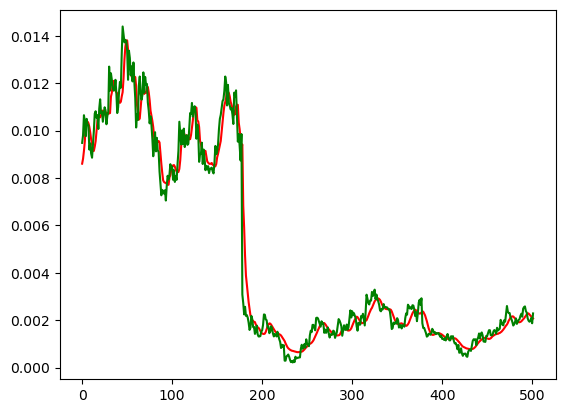

In [33]:
from matplotlib import pyplot as plt
pred_test = CNN_model.predict(X_test)
plt.plot(pred_test,'r')  # 예측 종가값(정규화된 값)
plt.plot(y_test,'g')     # 실제 종가값(정규화된 값)

## 아래 결과값 설명
- 피쳐데이터인 X_test의 10일분 데이터를 넣으면, 그 다음날의 종가를 예측해준다.
- 종가는 X_test의 4번째컬럼값들이다. X의 1번째 항의 첫째날부터 10째날의 데이터를 넣으면 
- y(예측종가)의 첫째항은 다음날인 X_test의 4번째컬럼의 20번째 종가값인 0.00947997이 나온다.
- X의 각 항은 1-10일, 2-11일, 3-12일 이런식으로 진행된다.
- 모든 값은 아직 정규화된 값이다.

In [78]:
# 정규화된 상태로 나옴
display(pred_test[:10])
display(y_test[:10])
display(X_test[:3])


array([[0.00860212],
       [0.00880767],
       [0.00914102],
       [0.00955235],
       [0.01022774],
       [0.01034622],
       [0.01037785],
       [0.01031339],
       [0.01015275],
       [0.00991679]], dtype=float32)

array([0.00947997, 0.00980025, 0.01064671, 0.01037981, 0.00976213,
       0.01049419, 0.01024254, 0.01021967, 0.00919782, 0.00945709],
      dtype=float32)

array([[[0.0097097 , 0.01049631, 0.00943526, 0.01045606],
        [0.01012507, 0.01026779, 0.00937339, 0.00930459],
        [0.00957124, 0.01026017, 0.00959768, 0.00948759],
        [0.00986355, 0.00982597, 0.00860771, 0.00838949],
        [0.00867898, 0.0090947 , 0.0086696 , 0.00893855],
        [0.00935587, 0.00924704, 0.00857678, 0.00872503],
        [0.00860976, 0.00889664, 0.00805087, 0.00811497],
        [0.00849437, 0.00842436, 0.00755588, 0.00743628],
        [0.00843091, 0.00882046, 0.00829836, 0.00860301],
        [0.00910973, 0.00924704, 0.0091491 , 0.00905293]],

       [[0.01012507, 0.01026779, 0.00937339, 0.00930459],
        [0.00957124, 0.01026017, 0.00959768, 0.00948759],
        [0.00986355, 0.00982597, 0.00860771, 0.00838949],
        [0.00867898, 0.0090947 , 0.0086696 , 0.00893855],
        [0.00935587, 0.00924704, 0.00857678, 0.00872503],
        [0.00860976, 0.00889664, 0.00805087, 0.00811497],
        [0.00849437, 0.00842436, 0.00755588, 0.00743628],
        [0.0

# 역정규화
- 정규화된 예측값을 실제 주가값으로 돌리기 위함
- in_val, max_val = minmax[column]에서 각 컬럼의 최소값과 최대값을 min_val, max_val 변수에 저장

In [35]:
display(minmax) # 각 컬럼의 최소,최댓값 -> 이를 이용하여 정규화했음
# 4번째 값 : 종가에 대한 최소/최댓값

[[0.23196400701999664, 72.77999877929688],
 [0.23553599417209625, 73.49250030517578],
 [0.22714300453662872, 72.37999725341797],
 [0.23428599536418915, 73.4124984741211]]

In [57]:
import numpy as np

def inverse_normalize_predictions(predictions, minmax):
    # 타겟(종가) 컬럼의 최소값과 최대값을 추출
    min_val, max_val = minmax[3] 
    predictions = (predictions * (max_val - min_val)) + min_val
    return predictions



In [58]:
# 역정규화 함수 테스트
num = 53.2143

# 정규화
min_val, max_val = minmax[3]   # min_val = minmax[3][0] , max_val = minmax[3][1]
normalized_num = (num - min_val) / (max_val - min_val)
print(normalized_num)

# 역정규화 식 테스트
inverse_num = (normalized_num * (max_val - min_val)) + min_val
print(inverse_num)
# 함수 테스트
inverse_num2 = inverse_normalize_predictions(normalized_num, minmax)
print(inverse_num2)

0.7239861730705095
53.2143
53.2143


In [64]:
# 역정규화 수행
real_pred_test = inverse_normalize_predictions(pred_test, minmax)
real_y_test = inverse_normalize_predictions(y_test, minmax)
display(len(real_pred_test),real_pred_test[0:10])
display(len(y_test),real_y_test[:10],real_y_test.max())

# 역정규화가 잘되었는지 확인해보려면, y_test의 결과값 array를 
# 맨 위에 df(원래데이터셋)의 11번째 행의 종가와 비교해보면된다. (1월 11일)

502

array([[0.86377364],
       [0.8788159 ],
       [0.9032096 ],
       [0.9333102 ],
       [0.98273396],
       [0.99140364],
       [0.99371845],
       [0.98900115],
       [0.97724634],
       [0.9599792 ]], dtype=float32)

502

array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
       1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],
      dtype=float32)

1.287388

# 실용화해보기
- 최근 주가데이터를 몇개가져와서 똑같이 정규화,전처리 후, 학습시킨 모델에 적용시켜본다.

In [94]:
# 데이터 수집
df2 = yfinance.download('AAPL','2023-12-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)


[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_83000/237320381.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_83000/237320381.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


'< original dataset >'

,Open,High,Low,Close
Date,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004
2024-01-05,181.990005,182.759995,180.169998,181.179993
2024-01-08,182.089996,185.600006,181.500000,185.559998
2024-01-09,183.919998,185.149994,182.729996,185.139999
2024-01-10,184.350006,186.399994,183.919998,186.190002
2024-01-11,186.539993,187.050003,183.619995,185.589996
2024-01-12,186.059998,186.740005,185.190002,185.919998
2024-01-16,182.160004,184.259995,180.929993,183.630005


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2023-12-01,0.540895,0.521946,0.538324,0.594212
2023-12-04,0.520000,0.432385,0.432561,0.487300
2023-12-05,0.533731,0.690391,0.594771,0.722977
2023-12-06,0.786865,0.711744,0.709448,0.658004
2023-12-07,0.737911,0.725979,0.797385,0.773184
2023-12-08,0.771940,0.784698,0.802139,0.858240
2023-12-11,0.706865,0.636418,0.668449,0.708801
2023-12-12,0.705074,0.709372,0.686275,0.799174
2023-12-13,0.825074,0.903915,0.872252,0.991140


(31, 4)

In [96]:
# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
display("new_X", new_X[:3], new_X.shape)
display("new_y", new_y, new_y.shape)

# 즉, 11번째인 2023-12-15의 종가부터 예측시작

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707

'new_X'

array([[[0.5408954 , 0.5219456 , 0.53832424, 0.59421194],
        [0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.82507414, 0.90391487, 0.8722523 , 0.99114037],
        [1.        , 1.        , 0.95008934, 1.        ]],

       [[0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.8

(21, 10, 4)

'new_y'

array([0.96810436, 0.8688718 , 0.93089205, 0.80626124, 0.7974007 ,
       0.73360944, 0.7011226 , 0.7070287 , 0.73242784, 0.6704076 ,
       0.26343796, 0.18133526, 0.04311935, 0.        , 0.2587125 ,
       0.2339046 , 0.29592484, 0.26048443, 0.27997658, 0.14471418,
       0.08860008], dtype=float32)

(21,)

In [103]:
# 모델로드
CNN_model = load_keras_model('adam','mse')

# 예측하기
print("[ 손실함수 ]")
pred_Apple = CNN_model.predict(new_X)
display(pred_Apple[:5], len(pred_Apple))

[ 손실함수 ]
1/1 [==============================] - 0s 54ms/step


2024-01-23 14:36:55.790299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.9132185 ],
       [0.92673534],
       [0.88122463],
       [0.9070041 ],
       [0.9212199 ]], dtype=float32)

21

1/1 [==============================] - 0s 8ms/step


array([[0.9132185 ],
       [0.92673534],
       [0.88122463],
       [0.9070041 ],
       [0.9212199 ]], dtype=float32)

21

[ 손실함수 ]
CNN MSE: 0.020675689


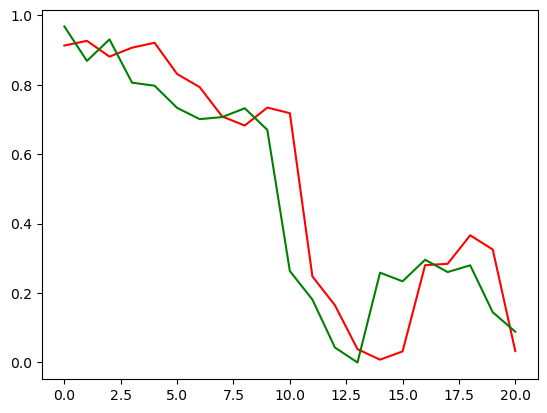

In [104]:
from sklearn.metrics import mean_squared_error

# 예측하기
pred_Apple = CNN_model.predict(new_X)
display(pred_Apple[:5], len(pred_Apple))

print("[ 손실함수 ]")
CNN_mse = mean_squared_error(new_y, pred_Apple)
print("CNN MSE:", CNN_mse)

# 정규화 예측값 시각화ㄴ
plt.plot(pred_Apple,'r')  # 예측 종가값(정규화된 값)
plt.plot(new_y,'g')     # 실제 종가값(정규화된 값)

In [101]:
# 역정규화
real_pred_Apple = inverse_normalize_predictions(pred_Apple, minmax)
real_new_y = inverse_normalize_predictions(new_y, minmax)
display(len(real_pred_Apple),real_pred_Apple[0:10])
display(len(real_new_y),real_new_y[:10])

21

array([[67.06198 ],
       [68.051125],
       [64.720726],
       [66.60722 ],
       [67.64751 ],
       [61.059383],
       [58.2915  ],
       [52.10119 ],
       [50.191578],
       [53.98079 ]], dtype=float32)

21

array([71.07843 , 63.816776, 68.3553  , 59.235046, 58.586647, 53.918518,
       51.541187, 51.973385, 53.83205 , 49.293518], dtype=float32)